In [18]:
%load_ext autoreload
%autoreload 2
from cs285.envs.pendulum.pendulum_env import PendulumEnv
from cs285.envs.dt_sampler import ConstantSampler
from cs285.infrastructure.replay_buffer import ReplayBufferTrajectories
from cs285.infrastructure.utils import sample_n_trajectories, RandomPolicy
from cs285.agents.ode_agent import ODEAgent
from cs285.agents.ode_agent_true_dynamics import ODEAgent_True_Dynamics
from typing import Callable, Optional, Tuple, Sequence
import numpy as np
import torch.nn as nn
import torch
import gym
from cs285.infrastructure import pytorch_util as ptu
from torchdiffeq import odeint
from tqdm import trange
import jax
import jax.numpy as jnp
import equinox as eqx
import diffrax
from diffrax import diffeqsolve, Dopri5
import optax
import matplotlib.pyplot as plt
import wandb
import pprint


import pprint


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
key = jax.random.PRNGKey(0)
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)
device = "cuda" if torch.cuda.is_available() else "cpu"
ptu.init_gpu(use_gpu=True if device=="cuda" else False)

gpu
Using GPU id 0


In [20]:
dt_sampler = ConstantSampler(dt=0.05)
env = PendulumEnv(
    dt_sampler=dt_sampler
)

In [21]:
def test_true_dynamics_agent(agent, ntraj):
    trajs, _ = sample_n_trajectories(env, agent, ntraj=ntraj, max_length=200, key=key)
    rewards = [t["episode_statistics"]["r"] for t in trajs]
    # plt.hist(returns, bins=20)
    mean, std, min, max = np.mean(rewards), np.std(rewards), np.min(rewards), np.max(rewards)
    print("mean", mean)
    print("std", std)
    print("min", min)
    print("max", max)
    stats = {
        "mean": mean,
        "std": std,
        "min": min,
        "max": max
    }
    return rewards, stats

100%|██████████| 10/10 [06:28<00:00, 38.85s/it]

mean -1207.9994
std 602.4616
min -1541.8062
max -3.2999287


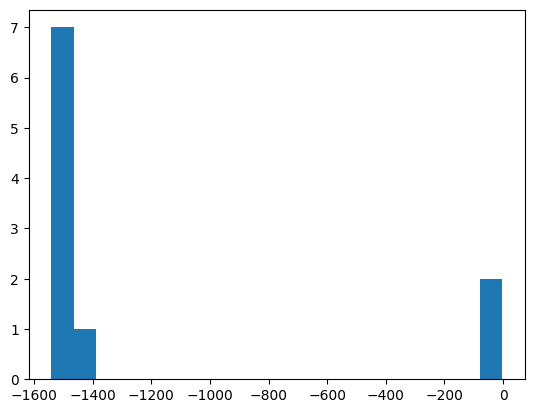

In [24]:
agent = ODEAgent_True_Dynamics(
    env=env,
    mpc_horizon_steps=100,
    mpc_timestep=0.005,
    mpc_strategy="cem",
    mpc_discount=0.9,
    mpc_num_action_sequences=1000,
    cem_num_iters=4,
    cem_num_elites=5,
    cem_alpha=1,
)
rewards, stats = test_true_dynamics_agent(agent, ntraj=10)


In [22]:
wandb.init()

/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


In [23]:
sweep_config = {
    'method': 'random'
    }
metric = {
    'name': 'mean',
    'goal': 'maximize'   
    }

sweep_config['metric'] = metric

parameters_dict = {
    'mpc_horizon_steps': {
        'values': [1, 2, 5, 10, 20, 50, 100, 200]
        },
    'mpc_timestep': {
        'value': 0.05
        },
    'mpc_discount': {
        'values': [1.0, 0.99, 0.95, 0.9, 0.8, 0.5]
        },
    "mpc_num_action_sequences": {
        'values': [100, 200, 500, 1000, 2000, 5000]
        },
    'mpc_strategy': {
        'values': ["random", "cem"]
        },
    'cem_num_iters': {
        'values': [2, 4, 8, 16],
        },
    'cem_num_elites': {
        'values': [1, 2, 4, 8, 16, 32, 64],
        },
    'cem_alpha': {
        'values': [1.0, 0.99, 0.95, 0.9, 0.8, 0.5],
        },
    }

sweep_config['parameters'] = parameters_dict
pprint.pprint(sweep_config)


{'method': 'random',
 'metric': {'goal': 'maximize', 'name': 'mean'},
 'parameters': {'cem_alpha': {'values': [1.0, 0.99, 0.95, 0.9, 0.8, 0.5]},
                'cem_num_elites': {'values': [1, 2, 4, 8, 16, 32, 64]},
                'cem_num_iters': {'values': [2, 4, 8, 16]},
                'mpc_discount': {'values': [1.0, 0.99, 0.95, 0.9, 0.8, 0.5]},
                'mpc_horizon_steps': {'values': [1,
                                                 2,
                                                 5,
                                                 10,
                                                 20,
                                                 50,
                                                 100,
                                                 200]},
                'mpc_num_action_sequences': {'values': [100,
                                                        200,
                                                        500,
                                     

In [24]:
sweep_id = wandb.sweep(sweep_config, project="cs285_proj_get_action_true_dynamics")

Create sweep with ID: a84q0755
Sweep URL: https://wandb.ai/zekai-wang/cs285_proj_get_action_true_dynamics/sweeps/a84q0755


In [25]:
def evaluate(config=None):
    with wandb.init(config=config):
        config = wandb.config
        agent = ODEAgent_True_Dynamics(
            env=env,
            mpc_horizon_steps=config.mpc_horizon_steps,
            mpc_timestep=config.mpc_timestep,
            mpc_strategy=config.mpc_strategy,
            mpc_discount=config.mpc_discount,
            mpc_num_action_sequences=config.mpc_num_action_sequences,
            cem_num_iters=config.cem_num_iters,
            cem_num_elites=config.cem_num_elites,
            cem_alpha=config.cem_alpha,
        )
        rewards, stats = test_true_dynamics_agent(agent, ntraj=10)
        wandb.log({"rewards": rewards,
                   "stats": stats,
                   "min": stats["min"],
                   "max": stats["max"],
                   "mean": stats["mean"],
                   "std": stats["std"],})


In [26]:
wandb.agent(sweep_id, evaluate, count=200)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


<IPython.core.display.HTML object>
<IPython.core.display.HTML object>


Exception in thread ChkStopThr:
Traceback (most recent call last):
  File "/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/threading.py", line 980, in _bootstrap_inner
Exception in thread NetStatThr:
Traceback (most recent call last):
  File "/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/threading.py", line 980, in _bootstrap_inner
Exception in thread IntMsgThr:
Traceback (most recent call last):
  File "/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/threading.py", line 980, in _bootstrap_inner
    self.run()
  File "/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/threading.py", line 917, in run
    self.run()
  File "/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/threading.py", line 917, in run
    self._target(*self._args, **self._kwargs)
  File "/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/wandb_run.py", line 268, in check_network_status
    self._loop_check_status(
  File "/home/zekai/miniconda3/envs/cs285_proj/lib/python

100%|██████████| 10/10 [03:49<00:00, 22.99s/it]


mean -722.0479
std 282.66434
min -1008.9755
max -129.62756


/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:89: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


max,▁
mean,▁
min,▁
std,▁
max,-129.62756
mean,-722.04791
min,-1008.97552
std,282.66434


wandb: Agent Starting Run: cx1nlers with config:
wandb: 	cem_alpha: 0.8
wandb: 	cem_num_elites: 32
wandb: 	cem_num_iters: 2
wandb: 	mpc_discount: 0.8
wandb: 	mpc_horizon_steps: 50
wandb: 	mpc_num_action_sequences: 2000
wandb: 	mpc_strategy: cem
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:89: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


100%|██████████| 10/10 [01:45<00:00, 10.51s/it]


mean -470.13452
std 547.89136
min -1523.1104
max -0.16351229


/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:89: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


max,▁
mean,▁
min,▁
std,▁
max,-0.16351
mean,-470.13452
min,-1523.11035
std,547.89136


wandb: Agent Starting Run: 56sa5n0j with config:
wandb: 	cem_alpha: 1
wandb: 	cem_num_elites: 4
wandb: 	cem_num_iters: 16
wandb: 	mpc_discount: 0.5
wandb: 	mpc_horizon_steps: 20
wandb: 	mpc_num_action_sequences: 100
wandb: 	mpc_strategy: random
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:32<00:00,  3.28s/it]


mean -1199.508
std 425.01773
min -1583.6694
max -0.62472725


/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:89: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


max,▁
mean,▁
min,▁
std,▁
max,-0.62473
mean,-1199.50806
min,-1583.66943
std,425.01773


wandb: Agent Starting Run: 8wiqshqg with config:
wandb: 	cem_alpha: 0.9
wandb: 	cem_num_elites: 32
wandb: 	cem_num_iters: 16
wandb: 	mpc_discount: 1
wandb: 	mpc_horizon_steps: 1
wandb: 	mpc_num_action_sequences: 2000
wandb: 	mpc_strategy: cem
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


  0%|          | 0/10 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/tmp/ipykernel_163285/2625986174.py", line 15, in evaluate
    rewards, stats = test_true_dynamics_agent(agent, ntraj=10)
  File "/tmp/ipykernel_163285/1321374163.py", line 2, in test_true_dynamics_agent
    trajs, _ = sample_n_trajectories(env, agent, ntraj=ntraj, max_length=200, key=key)
  File "/home/zekai/repos/cs285_proj/cs285/infrastructure/utils.py", line 123, in sample_n_trajectories
    traj = sample_trajectory(env, policy, max_length, sample_key, render)
  File "/home/zekai/repos/cs285_proj/cs285/infrastructure/utils.py", line 49, in sample_trajectory
    ac = policy.get_action(ob, key=ac_key)
  File "/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/equinox/_module.py", line 1011, in __call__
    return self.func(*self.args, *args, **kwargs, **self.keywords)
  File "/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/equinox/_jit.py", line 206, in __call__
    re

wandb: ERROR Run 8wiqshqg errored: AssertionError('u.shape=(), observations.shape=(1, 3)')
wandb: Agent Starting Run: iaqtuzlu with config:
wandb: 	cem_alpha: 0.8
wandb: 	cem_num_elites: 16
wandb: 	cem_num_iters: 4
wandb: 	mpc_discount: 0.95
wandb: 	mpc_horizon_steps: 200
wandb: 	mpc_num_action_sequences: 200
wandb: 	mpc_strategy: random
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [03:41<00:00, 22.14s/it]


mean -650.73206
std 345.2816
min -1076.7504
max -127.02426


max,▁
mean,▁
min,▁
std,▁
max,-127.02426
mean,-650.73206
min,-1076.75037
std,345.28159


wandb: Agent Starting Run: 5f0qry80 with config:
wandb: 	cem_alpha: 0.95
wandb: 	cem_num_elites: 4
wandb: 	cem_num_iters: 4
wandb: 	mpc_discount: 0.95
wandb: 	mpc_horizon_steps: 20
wandb: 	mpc_num_action_sequences: 2000
wandb: 	mpc_strategy: random
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:33<00:00,  3.31s/it]


mean -185.77225
std 125.30916
min -375.0008
max -0.8354941


max,▁
mean,▁
min,▁
std,▁
max,-0.83549
mean,-185.77225
min,-375.00079
std,125.30916


wandb: Agent Starting Run: qohpdand with config:
wandb: 	cem_alpha: 0.95
wandb: 	cem_num_elites: 32
wandb: 	cem_num_iters: 8
wandb: 	mpc_discount: 0.95
wandb: 	mpc_horizon_steps: 20
wandb: 	mpc_num_action_sequences: 200
wandb: 	mpc_strategy: random
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:33<00:00,  3.33s/it]


mean -176.6659
std 83.98125
min -378.369
max -121.10578


max,▁
mean,▁
min,▁
std,▁
max,-121.10578
mean,-176.66589
min,-378.36899
std,83.98125


wandb: Agent Starting Run: cjkgu6bo with config:
wandb: 	cem_alpha: 0.8
wandb: 	cem_num_elites: 1
wandb: 	cem_num_iters: 16
wandb: 	mpc_discount: 0.9
wandb: 	mpc_horizon_steps: 50
wandb: 	mpc_num_action_sequences: 1000
wandb: 	mpc_strategy: random
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [01:02<00:00,  6.25s/it]


mean -345.2695
std 201.13625
min -775.0681
max -127.29723


max,▁
mean,▁
min,▁
std,▁
max,-127.29723
mean,-345.2695
min,-775.06812
std,201.13625


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jtrvz2vd with config:
wandb: 	cem_alpha: 0.5
wandb: 	cem_num_elites: 16
wandb: 	cem_num_iters: 16
wandb: 	mpc_discount: 0.95
wandb: 	mpc_horizon_steps: 5
wandb: 	mpc_num_action_sequences: 5000
wandb: 	mpc_strategy: cem
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [01:16<00:00,  7.61s/it]


mean -765.1763
std 429.077
min -1499.3337
max -1.2019802


/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:89: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


max,▁
mean,▁
min,▁
std,▁
max,-1.20198
mean,-765.17627
min,-1499.33374
std,429.077


wandb: Agent Starting Run: 2dvg05g8 with config:
wandb: 	cem_alpha: 1
wandb: 	cem_num_elites: 4
wandb: 	cem_num_iters: 2
wandb: 	mpc_discount: 0.8
wandb: 	mpc_horizon_steps: 1
wandb: 	mpc_num_action_sequences: 100
wandb: 	mpc_strategy: cem
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


  0%|          | 0/10 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/tmp/ipykernel_163285/2625986174.py", line 15, in evaluate
    rewards, stats = test_true_dynamics_agent(agent, ntraj=10)
  File "/tmp/ipykernel_163285/1321374163.py", line 2, in test_true_dynamics_agent
    trajs, _ = sample_n_trajectories(env, agent, ntraj=ntraj, max_length=200, key=key)
  File "/home/zekai/repos/cs285_proj/cs285/infrastructure/utils.py", line 123, in sample_n_trajectories
    traj = sample_trajectory(env, policy, max_length, sample_key, render)
  File "/home/zekai/repos/cs285_proj/cs285/infrastructure/utils.py", line 49, in sample_trajectory
    ac = policy.get_action(ob, key=ac_key)
  File "/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/equinox/_module.py", line 1011, in __call__
    return self.func(*self.args, *args, **kwargs, **self.keywords)
  File "/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/equinox/_jit.py", line 206, in __call__
    re

wandb: ERROR Run 2dvg05g8 errored: AssertionError('u.shape=(), observations.shape=(1, 3)')
wandb: Agent Starting Run: ugmesd4g with config:
wandb: 	cem_alpha: 1
wandb: 	cem_num_elites: 2
wandb: 	cem_num_iters: 4
wandb: 	mpc_discount: 1
wandb: 	mpc_horizon_steps: 10
wandb: 	mpc_num_action_sequences: 5000
wandb: 	mpc_strategy: random
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:24<00:00,  2.45s/it]


mean -222.83838
std 138.26103
min -467.73108
max -0.23035496


/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:89: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


max,▁
mean,▁
min,▁
std,▁
max,-0.23035
mean,-222.83838
min,-467.73108
std,138.26103


wandb: Agent Starting Run: vjvb4aev with config:
wandb: 	cem_alpha: 0.95
wandb: 	cem_num_elites: 1
wandb: 	cem_num_iters: 8
wandb: 	mpc_discount: 0.5
wandb: 	mpc_horizon_steps: 2
wandb: 	mpc_num_action_sequences: 5000
wandb: 	mpc_strategy: random
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:18<00:00,  1.80s/it]


mean -1153.5754
std 575.4111
min -1515.1393
max -5.133054


/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:89: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


max,▁
mean,▁
min,▁
std,▁
max,-5.13305
mean,-1153.57544
min,-1515.13928
std,575.41107


wandb: Agent Starting Run: hcyy8hpi with config:
wandb: 	cem_alpha: 0.95
wandb: 	cem_num_elites: 1
wandb: 	cem_num_iters: 8
wandb: 	mpc_discount: 0.95
wandb: 	mpc_horizon_steps: 100
wandb: 	mpc_num_action_sequences: 1000
wandb: 	mpc_strategy: random
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [01:47<00:00, 10.74s/it]


mean -530.63116
std 398.6682
min -988.9552
max -2.1765714


/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:89: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


max,▁
mean,▁
min,▁
std,▁
max,-2.17657
mean,-530.63116
min,-988.9552
std,398.66821


wandb: Agent Starting Run: rvbvwzyd with config:
wandb: 	cem_alpha: 0.95
wandb: 	cem_num_elites: 4
wandb: 	cem_num_iters: 16
wandb: 	mpc_discount: 0.95
wandb: 	mpc_horizon_steps: 20
wandb: 	mpc_num_action_sequences: 100
wandb: 	mpc_strategy: random
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:33<00:00,  3.32s/it]


mean -304.21964
std 172.87614
min -647.41125
max -124.87016


max,▁
mean,▁
min,▁
std,▁
max,-124.87016
mean,-304.21964
min,-647.41125
std,172.87614


wandb: Agent Starting Run: 5ol95hr5 with config:
wandb: 	cem_alpha: 0.95
wandb: 	cem_num_elites: 2
wandb: 	cem_num_iters: 16
wandb: 	mpc_discount: 0.5
wandb: 	mpc_horizon_steps: 2
wandb: 	mpc_num_action_sequences: 5000
wandb: 	mpc_strategy: random
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:17<00:00,  1.77s/it]


mean -1324.9465
std 444.23563
min -1527.5701
max -9.7086525


max,▁
mean,▁
min,▁
std,▁
max,-9.70865
mean,-1324.94653
min,-1527.57007
std,444.23563


wandb: Agent Starting Run: a9eydi8p with config:
wandb: 	cem_alpha: 1
wandb: 	cem_num_elites: 4
wandb: 	cem_num_iters: 4
wandb: 	mpc_discount: 0.99
wandb: 	mpc_horizon_steps: 50
wandb: 	mpc_num_action_sequences: 200
wandb: 	mpc_strategy: cem
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [03:01<00:00, 18.13s/it]


mean -908.6068
std 347.9417
min -1177.5973
max -124.86674


max,▁
mean,▁
min,▁
std,▁
max,-124.86674
mean,-908.60681
min,-1177.59729
std,347.94171


wandb: Agent Starting Run: 1thkj5wz with config:
wandb: 	cem_alpha: 0.9
wandb: 	cem_num_elites: 16
wandb: 	cem_num_iters: 16
wandb: 	mpc_discount: 0.5
wandb: 	mpc_horizon_steps: 2
wandb: 	mpc_num_action_sequences: 200
wandb: 	mpc_strategy: cem
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:32<00:00,  3.22s/it]


mean -1272.6484
std 427.3072
min -1505.7975
max -3.8293586


max,▁
mean,▁
min,▁
std,▁
max,-3.82936
mean,-1272.64844
min,-1505.79749
std,427.30719


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1tvzfhjj with config:
wandb: 	cem_alpha: 0.95
wandb: 	cem_num_elites: 8
wandb: 	cem_num_iters: 16
wandb: 	mpc_discount: 0.8
wandb: 	mpc_horizon_steps: 200
wandb: 	mpc_num_action_sequences: 2000
wandb: 	mpc_strategy: cem
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [55:42<00:00, 334.28s/it]


mean -218.46883
std 162.02074
min -422.1762
max -0.0757904


max,▁
mean,▁
min,▁
std,▁
max,-0.07579
mean,-218.46883
min,-422.17621
std,162.02074


wandb: Agent Starting Run: 1bpd80xy with config:
wandb: 	cem_alpha: 0.8
wandb: 	cem_num_elites: 64
wandb: 	cem_num_iters: 2
wandb: 	mpc_discount: 0.99
wandb: 	mpc_horizon_steps: 50
wandb: 	mpc_num_action_sequences: 100
wandb: 	mpc_strategy: cem
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [01:42<00:00, 10.20s/it]


mean -1169.9779
std 138.97859
min -1388.8553
max -975.2386


max,▁
mean,▁
min,▁
std,▁
max,-975.23859
mean,-1169.97791
min,-1388.85535
std,138.97859


wandb: Agent Starting Run: 1o0gtx6d with config:
wandb: 	cem_alpha: 1
wandb: 	cem_num_elites: 1
wandb: 	cem_num_iters: 2
wandb: 	mpc_discount: 0.5
wandb: 	mpc_horizon_steps: 50
wandb: 	mpc_num_action_sequences: 100
wandb: 	mpc_strategy: cem
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [01:41<00:00, 10.18s/it]


mean -1167.4949
std 405.77652
min -1557.8247
max -0.45856136


max,▁
mean,▁
min,▁
std,▁
max,-0.45856
mean,-1167.49487
min,-1557.82471
std,405.77652


wandb: Agent Starting Run: mux778mh with config:
wandb: 	cem_alpha: 1
wandb: 	cem_num_elites: 4
wandb: 	cem_num_iters: 2
wandb: 	mpc_discount: 0.95
wandb: 	mpc_horizon_steps: 20
wandb: 	mpc_num_action_sequences: 2000
wandb: 	mpc_strategy: random
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:33<00:00,  3.31s/it]


mean -269.2664
std 175.29262
min -481.5804
max -0.50913435


max,▁
mean,▁
min,▁
std,▁
max,-0.50913
mean,-269.26639
min,-481.58041
std,175.29262


wandb: Agent Starting Run: jssggi4q with config:
wandb: 	cem_alpha: 1
wandb: 	cem_num_elites: 8
wandb: 	cem_num_iters: 2
wandb: 	mpc_discount: 0.8
wandb: 	mpc_horizon_steps: 5
wandb: 	mpc_num_action_sequences: 100
wandb: 	mpc_strategy: cem
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:24<00:00,  2.40s/it]


mean -991.70154
std 533.8713
min -1521.034
max -0.023132622


max,▁
mean,▁
min,▁
std,▁
max,-0.02313
mean,-991.70154
min,-1521.03406
std,533.87128


wandb: Agent Starting Run: uyju6657 with config:
wandb: 	cem_alpha: 1
wandb: 	cem_num_elites: 8
wandb: 	cem_num_iters: 8
wandb: 	mpc_discount: 0.95
wandb: 	mpc_horizon_steps: 20
wandb: 	mpc_num_action_sequences: 5000
wandb: 	mpc_strategy: cem
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [02:26<00:00, 14.63s/it]


mean -169.59006
std 73.76234
min -331.43518
max -120.0121


max,▁
mean,▁
min,▁
std,▁
max,-120.0121
mean,-169.59006
min,-331.43518
std,73.76234


wandb: Agent Starting Run: 8vb7fje6 with config:
wandb: 	cem_alpha: 0.99
wandb: 	cem_num_elites: 64
wandb: 	cem_num_iters: 16
wandb: 	mpc_discount: 0.95
wandb: 	mpc_horizon_steps: 2
wandb: 	mpc_num_action_sequences: 2000
wandb: 	mpc_strategy: cem
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:41<00:00,  4.17s/it]


mean -1255.6082
std 424.1091
min -1511.9454
max -5.3077908


max,▁
mean,▁
min,▁
std,▁
max,-5.30779
mean,-1255.60815
min,-1511.94543
std,424.1091


wandb: Agent Starting Run: gk9zm24e with config:
wandb: 	cem_alpha: 0.9
wandb: 	cem_num_elites: 16
wandb: 	cem_num_iters: 8
wandb: 	mpc_discount: 0.95
wandb: 	mpc_horizon_steps: 2
wandb: 	mpc_num_action_sequences: 1000
wandb: 	mpc_strategy: random
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:20<00:00,  2.08s/it]


mean -1415.05
std 83.95232
min -1518.004
max -1259.3063


max,▁
mean,▁
min,▁
std,▁
max,-1259.30627
mean,-1415.05005
min,-1518.00403
std,83.95232


wandb: Agent Starting Run: 5imb99ce with config:
wandb: 	cem_alpha: 0.95
wandb: 	cem_num_elites: 64
wandb: 	cem_num_iters: 4
wandb: 	mpc_discount: 0.8
wandb: 	mpc_horizon_steps: 50
wandb: 	mpc_num_action_sequences: 5000
wandb: 	mpc_strategy: random
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [01:07<00:00,  6.74s/it]


mean -421.27472
std 423.8277
min -1574.6954
max -0.51597667


max,▁
mean,▁
min,▁
std,▁
max,-0.51598
mean,-421.27472
min,-1574.69543
std,423.8277


wandb: Agent Starting Run: l3uvalvm with config:
wandb: 	cem_alpha: 0.99
wandb: 	cem_num_elites: 32
wandb: 	cem_num_iters: 8
wandb: 	mpc_discount: 0.8
wandb: 	mpc_horizon_steps: 200
wandb: 	mpc_num_action_sequences: 100
wandb: 	mpc_strategy: cem
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [29:10<00:00, 175.05s/it]


mean -392.7731
std 379.0013
min -1500.1643
max -131.59422


max,▁
mean,▁
min,▁
std,▁
max,-131.59422
mean,-392.7731
min,-1500.16431
std,379.00131


wandb: Agent Starting Run: m8x8rt4i with config:
wandb: 	cem_alpha: 0.5
wandb: 	cem_num_elites: 2
wandb: 	cem_num_iters: 4
wandb: 	mpc_discount: 0.9
wandb: 	mpc_horizon_steps: 200
wandb: 	mpc_num_action_sequences: 500
wandb: 	mpc_strategy: cem
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [14:28<00:00, 86.85s/it]


mean -225.61833
std 164.56987
min -504.96692
max -0.45413142


max,▁
mean,▁
min,▁
std,▁
max,-0.45413
mean,-225.61833
min,-504.96692
std,164.56987


wandb: Agent Starting Run: c37yh4vz with config:
wandb: 	cem_alpha: 0.5
wandb: 	cem_num_elites: 8
wandb: 	cem_num_iters: 2
wandb: 	mpc_discount: 0.9
wandb: 	mpc_horizon_steps: 200
wandb: 	mpc_num_action_sequences: 1000
wandb: 	mpc_strategy: cem
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [07:23<00:00, 44.35s/it]


mean -576.23505
std 430.65775
min -1087.0623
max -0.42501014


max,▁
mean,▁
min,▁
std,▁
max,-0.42501
mean,-576.23505
min,-1087.06226
std,430.65775


wandb: Agent Starting Run: ab8eexxx with config:
wandb: 	cem_alpha: 0.95
wandb: 	cem_num_elites: 1
wandb: 	cem_num_iters: 16
wandb: 	mpc_discount: 0.9
wandb: 	mpc_horizon_steps: 1
wandb: 	mpc_num_action_sequences: 100
wandb: 	mpc_strategy: cem
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


  0%|          | 0/10 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/tmp/ipykernel_163285/2625986174.py", line 15, in evaluate
    rewards, stats = test_true_dynamics_agent(agent, ntraj=10)
  File "/tmp/ipykernel_163285/1321374163.py", line 2, in test_true_dynamics_agent
    trajs, _ = sample_n_trajectories(env, agent, ntraj=ntraj, max_length=200, key=key)
  File "/home/zekai/repos/cs285_proj/cs285/infrastructure/utils.py", line 123, in sample_n_trajectories
    traj = sample_trajectory(env, policy, max_length, sample_key, render)
  File "/home/zekai/repos/cs285_proj/cs285/infrastructure/utils.py", line 49, in sample_trajectory
    ac = policy.get_action(ob, key=ac_key)
  File "/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/equinox/_module.py", line 1011, in __call__
    return self.func(*self.args, *args, **kwargs, **self.keywords)
  File "/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/equinox/_jit.py", line 206, in __call__
    re

wandb: ERROR Run ab8eexxx errored: AssertionError('u.shape=(), observations.shape=(1, 3)')
wandb: Agent Starting Run: 9o0a3lfd with config:
wandb: 	cem_alpha: 0.99
wandb: 	cem_num_elites: 2
wandb: 	cem_num_iters: 8
wandb: 	mpc_discount: 0.8
wandb: 	mpc_horizon_steps: 20
wandb: 	mpc_num_action_sequences: 500
wandb: 	mpc_strategy: random
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:33<00:00,  3.32s/it]


mean -474.55093
std 420.0522
min -1590.7954
max -0.31660005


max,▁
mean,▁
min,▁
std,▁
max,-0.3166
mean,-474.55093
min,-1590.79541
std,420.05219


wandb: Agent Starting Run: ru4iic8d with config:
wandb: 	cem_alpha: 0.5
wandb: 	cem_num_elites: 8
wandb: 	cem_num_iters: 4
wandb: 	mpc_discount: 0.99
wandb: 	mpc_horizon_steps: 20
wandb: 	mpc_num_action_sequences: 2000
wandb: 	mpc_strategy: random
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:32<00:00,  3.25s/it]


mean -159.08914
std 95.172424
min -366.68674
max -1.5500358


max,▁
mean,▁
min,▁
std,▁
max,-1.55004
mean,-159.08914
min,-366.68674
std,95.17242


wandb: Agent Starting Run: 219l4c0l with config:
wandb: 	cem_alpha: 0.5
wandb: 	cem_num_elites: 4
wandb: 	cem_num_iters: 8
wandb: 	mpc_discount: 0.8
wandb: 	mpc_horizon_steps: 5
wandb: 	mpc_num_action_sequences: 200
wandb: 	mpc_strategy: cem
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:43<00:00,  4.30s/it]


mean -864.6457
std 458.68332
min -1511.446
max -0.05648836


max,▁
mean,▁
min,▁
std,▁
max,-0.05649
mean,-864.64569
min,-1511.44604
std,458.68332


wandb: Agent Starting Run: nwkz7t71 with config:
wandb: 	cem_alpha: 0.99
wandb: 	cem_num_elites: 8
wandb: 	cem_num_iters: 2
wandb: 	mpc_discount: 0.95
wandb: 	mpc_horizon_steps: 10
wandb: 	mpc_num_action_sequences: 2000
wandb: 	mpc_strategy: cem
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:31<00:00,  3.16s/it]


mean -303.9799
std 412.73068
min -1503.4976
max -0.6791892


max,▁
mean,▁
min,▁
std,▁
max,-0.67919
mean,-303.97989
min,-1503.49756
std,412.73068


wandb: Agent Starting Run: gb5hdt01 with config:
wandb: 	cem_alpha: 0.8
wandb: 	cem_num_elites: 2
wandb: 	cem_num_iters: 4
wandb: 	mpc_discount: 0.99
wandb: 	mpc_horizon_steps: 200
wandb: 	mpc_num_action_sequences: 1000
wandb: 	mpc_strategy: random
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [03:45<00:00, 22.50s/it]


mean -1153.3885
std 81.77377
min -1304.1401
max -1027.3073


max,▁
mean,▁
min,▁
std,▁
max,-1027.30725
mean,-1153.38855
min,-1304.14014
std,81.77377


wandb: Agent Starting Run: 0wocut28 with config:
wandb: 	cem_alpha: 1
wandb: 	cem_num_elites: 8
wandb: 	cem_num_iters: 16
wandb: 	mpc_discount: 0.8
wandb: 	mpc_horizon_steps: 2
wandb: 	mpc_num_action_sequences: 200
wandb: 	mpc_strategy: cem
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:33<00:00,  3.38s/it]


mean -1275.9796
std 431.19962
min -1505.3167
max -0.13918273


max,▁
mean,▁
min,▁
std,▁
max,-0.13918
mean,-1275.97961
min,-1505.31665
std,431.19962


wandb: Agent Starting Run: 7sq2tm3d with config:
wandb: 	cem_alpha: 0.95
wandb: 	cem_num_elites: 4
wandb: 	cem_num_iters: 16
wandb: 	mpc_discount: 0.99
wandb: 	mpc_horizon_steps: 10
wandb: 	mpc_num_action_sequences: 200
wandb: 	mpc_strategy: cem
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [02:14<00:00, 13.46s/it]


mean -153.67493
std 55.89465
min -266.6317
max -122.14806


max,▁
mean,▁
min,▁
std,▁
max,-122.14806
mean,-153.67493
min,-266.63171
std,55.89465


wandb: Agent Starting Run: b12bg022 with config:
wandb: 	cem_alpha: 0.8
wandb: 	cem_num_elites: 8
wandb: 	cem_num_iters: 2
wandb: 	mpc_discount: 0.9
wandb: 	mpc_horizon_steps: 50
wandb: 	mpc_num_action_sequences: 5000
wandb: 	mpc_strategy: random
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [01:00<00:00,  6.02s/it]


mean -277.5974
std 176.2638
min -539.7661
max -2.9921298


max,▁
mean,▁
min,▁
std,▁
max,-2.99213
mean,-277.59741
min,-539.76611
std,176.26379


wandb: Agent Starting Run: g1qxz2zy with config:
wandb: 	cem_alpha: 0.5
wandb: 	cem_num_elites: 4
wandb: 	cem_num_iters: 4
wandb: 	mpc_discount: 0.99
wandb: 	mpc_horizon_steps: 100
wandb: 	mpc_num_action_sequences: 100
wandb: 	mpc_strategy: random
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [01:46<00:00, 10.66s/it]


mean -1077.8058
std 130.34451
min -1176.6357
max -712.2986


max,▁
mean,▁
min,▁
std,▁
max,-712.29858
mean,-1077.80579
min,-1176.63574
std,130.34451


wandb: Agent Starting Run: qrhvuq6b with config:
wandb: 	cem_alpha: 0.9
wandb: 	cem_num_elites: 16
wandb: 	cem_num_iters: 16
wandb: 	mpc_discount: 0.5
wandb: 	mpc_horizon_steps: 20
wandb: 	mpc_num_action_sequences: 500
wandb: 	mpc_strategy: cem
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [04:29<00:00, 26.94s/it]


mean -1271.8641
std 164.27975
min -1519.4441
max -1056.7677


max,▁
mean,▁
min,▁
std,▁
max,-1056.7677
mean,-1271.86414
min,-1519.44409
std,164.27975


wandb: Agent Starting Run: h575466b with config:
wandb: 	cem_alpha: 0.5
wandb: 	cem_num_elites: 32
wandb: 	cem_num_iters: 4
wandb: 	mpc_discount: 0.5
wandb: 	mpc_horizon_steps: 50
wandb: 	mpc_num_action_sequences: 100
wandb: 	mpc_strategy: random
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:58<00:00,  5.88s/it]


mean -1256.5037
std 114.54332
min -1576.0677
max -1141.5963


max,▁
mean,▁
min,▁
std,▁
max,-1141.59631
mean,-1256.50366
min,-1576.06775
std,114.54332


wandb: Agent Starting Run: vy142ou5 with config:
wandb: 	cem_alpha: 1
wandb: 	cem_num_elites: 1
wandb: 	cem_num_iters: 4
wandb: 	mpc_discount: 0.99
wandb: 	mpc_horizon_steps: 2
wandb: 	mpc_num_action_sequences: 200
wandb: 	mpc_strategy: random
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:17<00:00,  1.75s/it]


mean -1000.3878
std 660.9657
min -1521.381
max -0.030151088


max,▁
mean,▁
min,▁
std,▁
max,-0.03015
mean,-1000.38782
min,-1521.38098
std,660.9657


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: abihqspk with config:
wandb: 	cem_alpha: 0.99
wandb: 	cem_num_elites: 4
wandb: 	cem_num_iters: 8
wandb: 	mpc_discount: 0.5
wandb: 	mpc_horizon_steps: 20
wandb: 	mpc_num_action_sequences: 500
wandb: 	mpc_strategy: cem
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [02:25<00:00, 14.52s/it]


mean -1381.74
std 157.80426
min -1522.2096
max -1170.3741


max,▁
mean,▁
min,▁
std,▁
max,-1170.37415
mean,-1381.73999
min,-1522.20959
std,157.80426


wandb: Agent Starting Run: kliqd4pq with config:
wandb: 	cem_alpha: 0.8
wandb: 	cem_num_elites: 8
wandb: 	cem_num_iters: 2
wandb: 	mpc_discount: 0.99
wandb: 	mpc_horizon_steps: 1
wandb: 	mpc_num_action_sequences: 200
wandb: 	mpc_strategy: random
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


  0%|          | 0/10 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/tmp/ipykernel_163285/2625986174.py", line 15, in evaluate
    rewards, stats = test_true_dynamics_agent(agent, ntraj=10)
  File "/tmp/ipykernel_163285/1321374163.py", line 2, in test_true_dynamics_agent
    trajs, _ = sample_n_trajectories(env, agent, ntraj=ntraj, max_length=200, key=key)
  File "/home/zekai/repos/cs285_proj/cs285/infrastructure/utils.py", line 123, in sample_n_trajectories
    traj = sample_trajectory(env, policy, max_length, sample_key, render)
  File "/home/zekai/repos/cs285_proj/cs285/infrastructure/utils.py", line 49, in sample_trajectory
    ac = policy.get_action(ob, key=ac_key)
  File "/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/equinox/_module.py", line 1011, in __call__
    return self.func(*self.args, *args, **kwargs, **self.keywords)
  File "/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/equinox/_jit.py", line 206, in __call__
    re

wandb: ERROR Run kliqd4pq errored: AssertionError('u.shape=(), observations.shape=(1, 3)')
wandb: Agent Starting Run: d27jcdzm with config:
wandb: 	cem_alpha: 0.95
wandb: 	cem_num_elites: 16
wandb: 	cem_num_iters: 2
wandb: 	mpc_discount: 0.8
wandb: 	mpc_horizon_steps: 5
wandb: 	mpc_num_action_sequences: 2000
wandb: 	mpc_strategy: cem
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:23<00:00,  2.37s/it]


mean -861.97253
std 600.67664
min -1518.1448
max -0.17741565


max,▁
mean,▁
min,▁
std,▁
max,-0.17742
mean,-861.97253
min,-1518.14478
std,600.67664


wandb: Agent Starting Run: y9ppxjum with config:
wandb: 	cem_alpha: 0.95
wandb: 	cem_num_elites: 2
wandb: 	cem_num_iters: 4
wandb: 	mpc_discount: 0.5
wandb: 	mpc_horizon_steps: 200
wandb: 	mpc_num_action_sequences: 2000
wandb: 	mpc_strategy: random
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [03:50<00:00, 23.06s/it]


mean -1155.2682
std 422.3668
min -1545.5333
max -2.7400928


max,▁
mean,▁
min,▁
std,▁
max,-2.74009
mean,-1155.26819
min,-1545.53333
std,422.36679


wandb: Agent Starting Run: 90q3mw56 with config:
wandb: 	cem_alpha: 1
wandb: 	cem_num_elites: 16
wandb: 	cem_num_iters: 2
wandb: 	mpc_discount: 0.95
wandb: 	mpc_horizon_steps: 200
wandb: 	mpc_num_action_sequences: 200
wandb: 	mpc_strategy: random
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [03:44<00:00, 22.43s/it]


mean -899.77527
std 351.1585
min -1169.5648
max -1.9081748


max,▁
mean,▁
min,▁
std,▁
max,-1.90817
mean,-899.77527
min,-1169.56482
std,351.15851


wandb: Agent Starting Run: prxxx6yk with config:
wandb: 	cem_alpha: 1
wandb: 	cem_num_elites: 4
wandb: 	cem_num_iters: 16
wandb: 	mpc_discount: 0.9
wandb: 	mpc_horizon_steps: 5
wandb: 	mpc_num_action_sequences: 200
wandb: 	mpc_strategy: random
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:19<00:00,  1.98s/it]


mean -848.3546
std 582.50934
min -1569.7625
max -0.08887774


max,▁
mean,▁
min,▁
std,▁
max,-0.08888
mean,-848.35461
min,-1569.76245
std,582.50934


wandb: Agent Starting Run: irbkwyp0 with config:
wandb: 	cem_alpha: 0.5
wandb: 	cem_num_elites: 8
wandb: 	cem_num_iters: 8
wandb: 	mpc_discount: 0.5
wandb: 	mpc_horizon_steps: 5
wandb: 	mpc_num_action_sequences: 5000
wandb: 	mpc_strategy: cem
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:45<00:00,  4.52s/it]


mean -983.98926
std 515.05707
min -1505.2717
max -0.090458915


max,▁
mean,▁
min,▁
std,▁
max,-0.09046
mean,-983.98926
min,-1505.27173
std,515.05707


wandb: Agent Starting Run: nvqiut51 with config:
wandb: 	cem_alpha: 0.8
wandb: 	cem_num_elites: 4
wandb: 	cem_num_iters: 4
wandb: 	mpc_discount: 0.8
wandb: 	mpc_horizon_steps: 1
wandb: 	mpc_num_action_sequences: 2000
wandb: 	mpc_strategy: random
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


  0%|          | 0/10 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/tmp/ipykernel_163285/2625986174.py", line 15, in evaluate
    rewards, stats = test_true_dynamics_agent(agent, ntraj=10)
  File "/tmp/ipykernel_163285/1321374163.py", line 2, in test_true_dynamics_agent
    trajs, _ = sample_n_trajectories(env, agent, ntraj=ntraj, max_length=200, key=key)
  File "/home/zekai/repos/cs285_proj/cs285/infrastructure/utils.py", line 123, in sample_n_trajectories
    traj = sample_trajectory(env, policy, max_length, sample_key, render)
  File "/home/zekai/repos/cs285_proj/cs285/infrastructure/utils.py", line 49, in sample_trajectory
    ac = policy.get_action(ob, key=ac_key)
  File "/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/equinox/_module.py", line 1011, in __call__
    return self.func(*self.args, *args, **kwargs, **self.keywords)
  File "/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/equinox/_jit.py", line 206, in __call__
    re

wandb: ERROR Run nvqiut51 errored: AssertionError('u.shape=(), observations.shape=(1, 3)')
wandb: Agent Starting Run: 4wrzzpk7 with config:
wandb: 	cem_alpha: 0.99
wandb: 	cem_num_elites: 1
wandb: 	cem_num_iters: 8
wandb: 	mpc_discount: 0.8
wandb: 	mpc_horizon_steps: 200
wandb: 	mpc_num_action_sequences: 2000
wandb: 	mpc_strategy: random
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [03:50<00:00, 23.05s/it]


mean -296.08987
std 166.4606
min -590.64233
max -0.47160026


max,▁
mean,▁
min,▁
std,▁
max,-0.4716
mean,-296.08987
min,-590.64233
std,166.4606


wandb: Agent Starting Run: 9l8b13cm with config:
wandb: 	cem_alpha: 0.5
wandb: 	cem_num_elites: 4
wandb: 	cem_num_iters: 8
wandb: 	mpc_discount: 0.8
wandb: 	mpc_horizon_steps: 2
wandb: 	mpc_num_action_sequences: 2000
wandb: 	mpc_strategy: random
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:17<00:00,  1.72s/it]


mean -1271.7341
std 432.70203
min -1515.1384
max -0.030505957


max,▁
mean,▁
min,▁
std,▁
max,-0.03051
mean,-1271.73413
min,-1515.13843
std,432.70203


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: sx7nio1t with config:
wandb: 	cem_alpha: 1
wandb: 	cem_num_elites: 2
wandb: 	cem_num_iters: 16
wandb: 	mpc_discount: 0.9
wandb: 	mpc_horizon_steps: 200
wandb: 	mpc_num_action_sequences: 5000
wandb: 	mpc_strategy: cem
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [58:32<00:00, 351.23s/it]


mean -230.12924
std 106.1536
min -384.47913
max -121.83134


max,▁
mean,▁
min,▁
std,▁
max,-121.83134
mean,-230.12924
min,-384.47913
std,106.1536


wandb: Agent Starting Run: kk3ssm40 with config:
wandb: 	cem_alpha: 0.5
wandb: 	cem_num_elites: 2
wandb: 	cem_num_iters: 16
wandb: 	mpc_discount: 1
wandb: 	mpc_horizon_steps: 50
wandb: 	mpc_num_action_sequences: 5000
wandb: 	mpc_strategy: random
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [01:00<00:00,  6.08s/it]


mean -925.6585
std 311.91638
min -1247.7969
max -250.31448


max,▁
mean,▁
min,▁
std,▁
max,-250.31448
mean,-925.65851
min,-1247.79688
std,311.91638


wandb: Agent Starting Run: bvnyg46r with config:
wandb: 	cem_alpha: 0.8
wandb: 	cem_num_elites: 16
wandb: 	cem_num_iters: 2
wandb: 	mpc_discount: 0.9
wandb: 	mpc_horizon_steps: 200
wandb: 	mpc_num_action_sequences: 200
wandb: 	mpc_strategy: random
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [03:44<00:00, 22.45s/it]


mean -393.3066
std 266.151
min -874.47107
max -3.0525799


max,▁
mean,▁
min,▁
std,▁
max,-3.05258
mean,-393.30661
min,-874.47107
std,266.151


wandb: Agent Starting Run: jbji7lig with config:
wandb: 	cem_alpha: 0.95
wandb: 	cem_num_elites: 16
wandb: 	cem_num_iters: 16
wandb: 	mpc_discount: 0.8
wandb: 	mpc_horizon_steps: 20
wandb: 	mpc_num_action_sequences: 2000
wandb: 	mpc_strategy: random
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:32<00:00,  3.29s/it]


mean -520.9856
std 480.16055
min -1579.6932
max -0.22249283


max,▁
mean,▁
min,▁
std,▁
max,-0.22249
mean,-520.9856
min,-1579.69324
std,480.16055


wandb: Agent Starting Run: 57d9h22t with config:
wandb: 	cem_alpha: 0.5
wandb: 	cem_num_elites: 32
wandb: 	cem_num_iters: 16
wandb: 	mpc_discount: 0.5
wandb: 	mpc_horizon_steps: 10
wandb: 	mpc_num_action_sequences: 500
wandb: 	mpc_strategy: cem
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [02:15<00:00, 13.52s/it]


mean -1049.6362
std 360.80957
min -1271.4504
max -0.47123918


max,▁
mean,▁
min,▁
std,▁
max,-0.47124
mean,-1049.63623
min,-1271.45044
std,360.80957


wandb: Agent Starting Run: vrlhcmup with config:
wandb: 	cem_alpha: 0.95
wandb: 	cem_num_elites: 32
wandb: 	cem_num_iters: 16
wandb: 	mpc_discount: 0.5
wandb: 	mpc_horizon_steps: 10
wandb: 	mpc_num_action_sequences: 2000
wandb: 	mpc_strategy: cem
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [02:16<00:00, 13.61s/it]


mean -969.37646
std 495.24573
min -1505.3829
max -0.13965608


max,▁
mean,▁
min,▁
std,▁
max,-0.13966
mean,-969.37646
min,-1505.38293
std,495.24573


wandb: Agent Starting Run: d4n6ah2w with config:
wandb: 	cem_alpha: 0.95
wandb: 	cem_num_elites: 8
wandb: 	cem_num_iters: 8
wandb: 	mpc_discount: 0.8
wandb: 	mpc_horizon_steps: 2
wandb: 	mpc_num_action_sequences: 1000
wandb: 	mpc_strategy: random
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:17<00:00,  1.71s/it]


mean -1358.6584
std 91.28192
min -1516.2783
max -1238.8188


max,▁
mean,▁
min,▁
std,▁
max,-1238.81885
mean,-1358.65845
min,-1516.27832
std,91.28192


wandb: Agent Starting Run: uhtdtwhj with config:
wandb: 	cem_alpha: 0.5
wandb: 	cem_num_elites: 32
wandb: 	cem_num_iters: 16
wandb: 	mpc_discount: 1
wandb: 	mpc_horizon_steps: 5
wandb: 	mpc_num_action_sequences: 500
wandb: 	mpc_strategy: random
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:19<00:00,  1.96s/it]


mean -823.4546
std 576.9325
min -1554.766
max -0.17711712


max,▁
mean,▁
min,▁
std,▁
max,-0.17712
mean,-823.45459
min,-1554.76599
std,576.9325


wandb: Agent Starting Run: 0hwa2utb with config:
wandb: 	cem_alpha: 0.9
wandb: 	cem_num_elites: 8
wandb: 	cem_num_iters: 16
wandb: 	mpc_discount: 0.9
wandb: 	mpc_horizon_steps: 200
wandb: 	mpc_num_action_sequences: 5000
wandb: 	mpc_strategy: random
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [03:58<00:00, 23.81s/it]


mean -228.70952
std 136.99304
min -395.0283
max -1.7622826


max,▁
mean,▁
min,▁
std,▁
max,-1.76228
mean,-228.70952
min,-395.02829
std,136.99304


wandb: Agent Starting Run: ugz3fwfv with config:
wandb: 	cem_alpha: 0.9
wandb: 	cem_num_elites: 64
wandb: 	cem_num_iters: 4
wandb: 	mpc_discount: 0.9
wandb: 	mpc_horizon_steps: 1
wandb: 	mpc_num_action_sequences: 100
wandb: 	mpc_strategy: random
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


  0%|          | 0/10 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/tmp/ipykernel_163285/2625986174.py", line 15, in evaluate
    rewards, stats = test_true_dynamics_agent(agent, ntraj=10)
  File "/tmp/ipykernel_163285/1321374163.py", line 2, in test_true_dynamics_agent
    trajs, _ = sample_n_trajectories(env, agent, ntraj=ntraj, max_length=200, key=key)
  File "/home/zekai/repos/cs285_proj/cs285/infrastructure/utils.py", line 123, in sample_n_trajectories
    traj = sample_trajectory(env, policy, max_length, sample_key, render)
  File "/home/zekai/repos/cs285_proj/cs285/infrastructure/utils.py", line 49, in sample_trajectory
    ac = policy.get_action(ob, key=ac_key)
  File "/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/equinox/_module.py", line 1011, in __call__
    return self.func(*self.args, *args, **kwargs, **self.keywords)
  File "/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/equinox/_jit.py", line 206, in __call__
    re

wandb: ERROR Run ugz3fwfv errored: AssertionError('u.shape=(), observations.shape=(1, 3)')
wandb: Agent Starting Run: 8365a1bu with config:
wandb: 	cem_alpha: 1
wandb: 	cem_num_elites: 1
wandb: 	cem_num_iters: 8
wandb: 	mpc_discount: 1
wandb: 	mpc_horizon_steps: 10
wandb: 	mpc_num_action_sequences: 1000
wandb: 	mpc_strategy: random
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:23<00:00,  2.39s/it]


mean -232.90251
std 203.11737
min -746.7421
max -0.24310064


max,▁
mean,▁
min,▁
std,▁
max,-0.2431
mean,-232.90251
min,-746.74213
std,203.11737


wandb: Agent Starting Run: wjizsme5 with config:
wandb: 	cem_alpha: 0.9
wandb: 	cem_num_elites: 8
wandb: 	cem_num_iters: 16
wandb: 	mpc_discount: 0.8
wandb: 	mpc_horizon_steps: 5
wandb: 	mpc_num_action_sequences: 100
wandb: 	mpc_strategy: cem
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [01:10<00:00,  7.09s/it]


mean -1116.4348
std 438.27267
min -1518.5142
max -2.7107465


max,▁
mean,▁
min,▁
std,▁
max,-2.71075
mean,-1116.43481
min,-1518.51416
std,438.27267


wandb: Agent Starting Run: vjosgqif with config:
wandb: 	cem_alpha: 0.95
wandb: 	cem_num_elites: 64
wandb: 	cem_num_iters: 2
wandb: 	mpc_discount: 0.5
wandb: 	mpc_horizon_steps: 100
wandb: 	mpc_num_action_sequences: 200
wandb: 	mpc_strategy: random
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [01:46<00:00, 10.63s/it]


mean -797.0812
std 663.5217
min -1569.6216
max -0.16919944


max,▁
mean,▁
min,▁
std,▁
max,-0.1692
mean,-797.08118
min,-1569.62158
std,663.52173


wandb: Agent Starting Run: z5x13rs2 with config:
wandb: 	cem_alpha: 1
wandb: 	cem_num_elites: 1
wandb: 	cem_num_iters: 16
wandb: 	mpc_discount: 0.5
wandb: 	mpc_horizon_steps: 10
wandb: 	mpc_num_action_sequences: 1000
wandb: 	mpc_strategy: random
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:24<00:00,  2.41s/it]


mean -1056.8218
std 552.3577
min -1542.1072
max -0.12192146


max,▁
mean,▁
min,▁
std,▁
max,-0.12192
mean,-1056.82178
min,-1542.10718
std,552.35773


wandb: Agent Starting Run: hlcv9tvw with config:
wandb: 	cem_alpha: 0.8
wandb: 	cem_num_elites: 8
wandb: 	cem_num_iters: 16
wandb: 	mpc_discount: 0.9
wandb: 	mpc_horizon_steps: 2
wandb: 	mpc_num_action_sequences: 500
wandb: 	mpc_strategy: cem
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:36<00:00,  3.63s/it]


mean -1208.0442
std 407.37656
min -1509.438
max -0.3760862


max,▁
mean,▁
min,▁
std,▁
max,-0.37609
mean,-1208.04419
min,-1509.43799
std,407.37656


wandb: Agent Starting Run: bgn544mg with config:
wandb: 	cem_alpha: 0.9
wandb: 	cem_num_elites: 4
wandb: 	cem_num_iters: 4
wandb: 	mpc_discount: 0.8
wandb: 	mpc_horizon_steps: 5
wandb: 	mpc_num_action_sequences: 100
wandb: 	mpc_strategy: cem
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:33<00:00,  3.35s/it]


mean -1020.0123
std 368.38464
min -1510.2407
max -1.516255


max,▁
mean,▁
min,▁
std,▁
max,-1.51626
mean,-1020.01233
min,-1510.24072
std,368.38464


wandb: Agent Starting Run: vrv0ptjb with config:
wandb: 	cem_alpha: 0.5
wandb: 	cem_num_elites: 4
wandb: 	cem_num_iters: 4
wandb: 	mpc_discount: 0.8
wandb: 	mpc_horizon_steps: 5
wandb: 	mpc_num_action_sequences: 1000
wandb: 	mpc_strategy: random
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:22<00:00,  2.22s/it]


mean -1036.5433
std 400.75925
min -1544.3427
max -0.061981555


max,▁
mean,▁
min,▁
std,▁
max,-0.06198
mean,-1036.54333
min,-1544.34265
std,400.75925


wandb: Agent Starting Run: 3zlq58ma with config:
wandb: 	cem_alpha: 1
wandb: 	cem_num_elites: 2
wandb: 	cem_num_iters: 2
wandb: 	mpc_discount: 0.99
wandb: 	mpc_horizon_steps: 2
wandb: 	mpc_num_action_sequences: 1000
wandb: 	mpc_strategy: random
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:20<00:00,  2.00s/it]


mean -1205.6829
std 407.32678
min -1511.1918
max -0.8149917


max,▁
mean,▁
min,▁
std,▁
max,-0.81499
mean,-1205.68286
min,-1511.19177
std,407.32678


wandb: Agent Starting Run: g69p5n2q with config:
wandb: 	cem_alpha: 0.9
wandb: 	cem_num_elites: 16
wandb: 	cem_num_iters: 16
wandb: 	mpc_discount: 0.99
wandb: 	mpc_horizon_steps: 200
wandb: 	mpc_num_action_sequences: 5000
wandb: 	mpc_strategy: random
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [04:06<00:00, 24.65s/it]


mean -1145.5562
std 91.12908
min -1290.0222
max -973.8064


max,▁
mean,▁
min,▁
std,▁
max,-973.8064
mean,-1145.55615
min,-1290.02222
std,91.12908


wandb: Agent Starting Run: htjhd7eu with config:
wandb: 	cem_alpha: 0.5
wandb: 	cem_num_elites: 16
wandb: 	cem_num_iters: 8
wandb: 	mpc_discount: 0.8
wandb: 	mpc_horizon_steps: 100
wandb: 	mpc_num_action_sequences: 5000
wandb: 	mpc_strategy: random
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [01:59<00:00, 11.91s/it]


mean -223.62886
std 212.97203
min -534.0811
max -0.34461945


max,▁
mean,▁
min,▁
std,▁
max,-0.34462
mean,-223.62886
min,-534.08112
std,212.97203


wandb: Agent Starting Run: gigtd8lg with config:
wandb: 	cem_alpha: 0.95
wandb: 	cem_num_elites: 2
wandb: 	cem_num_iters: 2
wandb: 	mpc_discount: 0.9
wandb: 	mpc_horizon_steps: 20
wandb: 	mpc_num_action_sequences: 100
wandb: 	mpc_strategy: cem
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:51<00:00,  5.17s/it]


mean -191.4804
std 153.32484
min -506.9973
max -0.433596


max,▁
mean,▁
min,▁
std,▁
max,-0.4336
mean,-191.48039
min,-506.99731
std,153.32484


wandb: Agent Starting Run: uc3eojzb with config:
wandb: 	cem_alpha: 1
wandb: 	cem_num_elites: 1
wandb: 	cem_num_iters: 8
wandb: 	mpc_discount: 0.95
wandb: 	mpc_horizon_steps: 50
wandb: 	mpc_num_action_sequences: 500
wandb: 	mpc_strategy: cem
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [06:16<00:00, 37.67s/it]


mean -431.51324
std 390.05402
min -1029.1826
max -1.4625889


max,▁
mean,▁
min,▁
std,▁
max,-1.46259
mean,-431.51324
min,-1029.18262
std,390.05402


wandb: Agent Starting Run: g871ueoo with config:
wandb: 	cem_alpha: 1
wandb: 	cem_num_elites: 2
wandb: 	cem_num_iters: 16
wandb: 	mpc_discount: 0.5
wandb: 	mpc_horizon_steps: 200
wandb: 	mpc_num_action_sequences: 5000
wandb: 	mpc_strategy: cem
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [1:00:12<00:00, 361.23s/it]


mean -1255.2537
std 167.60992
min -1508.7832
max -1080.8427


max,▁
mean,▁
min,▁
std,▁
max,-1080.84265
mean,-1255.25366
min,-1508.7832
std,167.60992


wandb: Agent Starting Run: j7vy8tdp with config:
wandb: 	cem_alpha: 0.9
wandb: 	cem_num_elites: 8
wandb: 	cem_num_iters: 8
wandb: 	mpc_discount: 0.5
wandb: 	mpc_horizon_steps: 2
wandb: 	mpc_num_action_sequences: 2000
wandb: 	mpc_strategy: random
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:18<00:00,  1.88s/it]


mean -1131.2644
std 566.35876
min -1511.547
max -4.0308604


max,▁
mean,▁
min,▁
std,▁
max,-4.03086
mean,-1131.2644
min,-1511.547
std,566.35876


wandb: Agent Starting Run: 9t9qb3iy with config:
wandb: 	cem_alpha: 0.8
wandb: 	cem_num_elites: 32
wandb: 	cem_num_iters: 2
wandb: 	mpc_discount: 0.99
wandb: 	mpc_horizon_steps: 5
wandb: 	mpc_num_action_sequences: 200
wandb: 	mpc_strategy: random
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:21<00:00,  2.18s/it]


mean -846.6756
std 458.32803
min -1568.3739
max -1.1580155


max,▁
mean,▁
min,▁
std,▁
max,-1.15802
mean,-846.6756
min,-1568.3739
std,458.32803


wandb: Agent Starting Run: 7tq71qp6 with config:
wandb: 	cem_alpha: 0.5
wandb: 	cem_num_elites: 1
wandb: 	cem_num_iters: 2
wandb: 	mpc_discount: 0.95
wandb: 	mpc_horizon_steps: 20
wandb: 	mpc_num_action_sequences: 1000
wandb: 	mpc_strategy: cem
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:49<00:00,  4.92s/it]


mean -224.96994
std 164.206
min -622.32007
max -0.40122133


max,▁
mean,▁
min,▁
std,▁
max,-0.40122
mean,-224.96994
min,-622.32007
std,164.20599


wandb: Agent Starting Run: 3837fjmj with config:
wandb: 	cem_alpha: 0.5
wandb: 	cem_num_elites: 64
wandb: 	cem_num_iters: 16
wandb: 	mpc_discount: 1
wandb: 	mpc_horizon_steps: 1
wandb: 	mpc_num_action_sequences: 100
wandb: 	mpc_strategy: random
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


  0%|          | 0/10 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/tmp/ipykernel_163285/2625986174.py", line 15, in evaluate
    rewards, stats = test_true_dynamics_agent(agent, ntraj=10)
  File "/tmp/ipykernel_163285/1321374163.py", line 2, in test_true_dynamics_agent
    trajs, _ = sample_n_trajectories(env, agent, ntraj=ntraj, max_length=200, key=key)
  File "/home/zekai/repos/cs285_proj/cs285/infrastructure/utils.py", line 123, in sample_n_trajectories
    traj = sample_trajectory(env, policy, max_length, sample_key, render)
  File "/home/zekai/repos/cs285_proj/cs285/infrastructure/utils.py", line 49, in sample_trajectory
    ac = policy.get_action(ob, key=ac_key)
  File "/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/equinox/_module.py", line 1011, in __call__
    return self.func(*self.args, *args, **kwargs, **self.keywords)
  File "/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/equinox/_jit.py", line 206, in __call__
    re

wandb: ERROR Run 3837fjmj errored: AssertionError('u.shape=(), observations.shape=(1, 3)')
wandb: Agent Starting Run: qyi61077 with config:
wandb: 	cem_alpha: 0.9
wandb: 	cem_num_elites: 8
wandb: 	cem_num_iters: 8
wandb: 	mpc_discount: 0.5
wandb: 	mpc_horizon_steps: 100
wandb: 	mpc_num_action_sequences: 100
wandb: 	mpc_strategy: cem
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [12:30<00:00, 75.07s/it]


mean -1150.0887
std 413.99557
min -1514.3716
max -0.13879225


max,▁
mean,▁
min,▁
std,▁
max,-0.13879
mean,-1150.08875
min,-1514.37158
std,413.99557


wandb: Agent Starting Run: n0suhrrw with config:
wandb: 	cem_alpha: 0.5
wandb: 	cem_num_elites: 2
wandb: 	cem_num_iters: 4
wandb: 	mpc_discount: 0.9
wandb: 	mpc_horizon_steps: 50
wandb: 	mpc_num_action_sequences: 500
wandb: 	mpc_strategy: random
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:58<00:00,  5.87s/it]


mean -408.33868
std 220.7459
min -757.82776
max -2.0734687


max,▁
mean,▁
min,▁
std,▁
max,-2.07347
mean,-408.33868
min,-757.82776
std,220.7459


wandb: Agent Starting Run: u0m9bkd4 with config:
wandb: 	cem_alpha: 0.95
wandb: 	cem_num_elites: 64
wandb: 	cem_num_iters: 16
wandb: 	mpc_discount: 0.5
wandb: 	mpc_horizon_steps: 20
wandb: 	mpc_num_action_sequences: 500
wandb: 	mpc_strategy: cem
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [04:29<00:00, 26.92s/it]


mean -969.3666
std 494.93964
min -1502.2231
max -1.8125548


max,▁
mean,▁
min,▁
std,▁
max,-1.81255
mean,-969.36658
min,-1502.22314
std,494.93964


wandb: Agent Starting Run: 3wka3pje with config:
wandb: 	cem_alpha: 0.5
wandb: 	cem_num_elites: 8
wandb: 	cem_num_iters: 16
wandb: 	mpc_discount: 0.95
wandb: 	mpc_horizon_steps: 20
wandb: 	mpc_num_action_sequences: 5000
wandb: 	mpc_strategy: random
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:32<00:00,  3.24s/it]


mean -100.05522
std 49.69961
min -130.41704
max -0.67280555


max,▁
mean,▁
min,▁
std,▁
max,-0.67281
mean,-100.05522
min,-130.41704
std,49.69961


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: kqqgy90t with config:
wandb: 	cem_alpha: 0.99
wandb: 	cem_num_elites: 1
wandb: 	cem_num_iters: 2
wandb: 	mpc_discount: 0.5
wandb: 	mpc_horizon_steps: 200
wandb: 	mpc_num_action_sequences: 500
wandb: 	mpc_strategy: random
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [03:44<00:00, 22.46s/it]


mean -1154.343
std 411.52936
min -1551.5759
max -2.9323177


max,▁
mean,▁
min,▁
std,▁
max,-2.93232
mean,-1154.34302
min,-1551.57593
std,411.52936


wandb: Agent Starting Run: 0drklaos with config:
wandb: 	cem_alpha: 0.5
wandb: 	cem_num_elites: 4
wandb: 	cem_num_iters: 16
wandb: 	mpc_discount: 0.9
wandb: 	mpc_horizon_steps: 1
wandb: 	mpc_num_action_sequences: 500
wandb: 	mpc_strategy: random
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


  0%|          | 0/10 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/tmp/ipykernel_163285/2625986174.py", line 15, in evaluate
    rewards, stats = test_true_dynamics_agent(agent, ntraj=10)
  File "/tmp/ipykernel_163285/1321374163.py", line 2, in test_true_dynamics_agent
    trajs, _ = sample_n_trajectories(env, agent, ntraj=ntraj, max_length=200, key=key)
  File "/home/zekai/repos/cs285_proj/cs285/infrastructure/utils.py", line 123, in sample_n_trajectories
    traj = sample_trajectory(env, policy, max_length, sample_key, render)
  File "/home/zekai/repos/cs285_proj/cs285/infrastructure/utils.py", line 49, in sample_trajectory
    ac = policy.get_action(ob, key=ac_key)
  File "/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/equinox/_module.py", line 1011, in __call__
    return self.func(*self.args, *args, **kwargs, **self.keywords)
  File "/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/equinox/_jit.py", line 206, in __call__
    re

wandb: ERROR Run 0drklaos errored: AssertionError('u.shape=(), observations.shape=(1, 3)')
wandb: Agent Starting Run: 52992631 with config:
wandb: 	cem_alpha: 0.9
wandb: 	cem_num_elites: 8
wandb: 	cem_num_iters: 2
wandb: 	mpc_discount: 0.9
wandb: 	mpc_horizon_steps: 10
wandb: 	mpc_num_action_sequences: 2000
wandb: 	mpc_strategy: random
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:24<00:00,  2.41s/it]


mean -229.59457
std 283.7479
min -992.9061
max -0.38896728


max,▁
mean,▁
min,▁
std,▁
max,-0.38897
mean,-229.59457
min,-992.90613
std,283.74789


wandb: Agent Starting Run: b1o9oz07 with config:
wandb: 	cem_alpha: 0.95
wandb: 	cem_num_elites: 64
wandb: 	cem_num_iters: 16
wandb: 	mpc_discount: 0.99
wandb: 	mpc_horizon_steps: 2
wandb: 	mpc_num_action_sequences: 1000
wandb: 	mpc_strategy: cem
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:34<00:00,  3.46s/it]


mean -1378.9323
std 84.18457
min -1503.9478
max -1269.9705


max,▁
mean,▁
min,▁
std,▁
max,-1269.97046
mean,-1378.93225
min,-1503.94775
std,84.18457


wandb: Agent Starting Run: 8ehoyo2b with config:
wandb: 	cem_alpha: 0.95
wandb: 	cem_num_elites: 32
wandb: 	cem_num_iters: 16
wandb: 	mpc_discount: 0.8
wandb: 	mpc_horizon_steps: 20
wandb: 	mpc_num_action_sequences: 500
wandb: 	mpc_strategy: cem
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [04:27<00:00, 26.74s/it]


mean -325.39282
std 405.5516
min -1499.6084
max -0.91835


max,▁
mean,▁
min,▁
std,▁
max,-0.91835
mean,-325.39282
min,-1499.6084
std,405.55161


wandb: Agent Starting Run: m7fektx4 with config:
wandb: 	cem_alpha: 0.9
wandb: 	cem_num_elites: 1
wandb: 	cem_num_iters: 8
wandb: 	mpc_discount: 1
wandb: 	mpc_horizon_steps: 100
wandb: 	mpc_num_action_sequences: 200
wandb: 	mpc_strategy: random
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [01:46<00:00, 10.64s/it]


mean -1134.7107
std 50.520405
min -1230.8077
max -1065.2423


max,▁
mean,▁
min,▁
std,▁
max,-1065.24231
mean,-1134.71069
min,-1230.80774
std,50.5204


wandb: Agent Starting Run: c3ibckb2 with config:
wandb: 	cem_alpha: 0.5
wandb: 	cem_num_elites: 16
wandb: 	cem_num_iters: 16
wandb: 	mpc_discount: 0.9
wandb: 	mpc_horizon_steps: 5
wandb: 	mpc_num_action_sequences: 1000
wandb: 	mpc_strategy: cem
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [01:11<00:00,  7.17s/it]


mean -1024.8652
std 163.89369
min -1506.659
max -921.11316


max,▁
mean,▁
min,▁
std,▁
max,-921.11316
mean,-1024.86523
min,-1506.65906
std,163.89369


wandb: Agent Starting Run: oevqfvk5 with config:
wandb: 	cem_alpha: 1
wandb: 	cem_num_elites: 4
wandb: 	cem_num_iters: 4
wandb: 	mpc_discount: 0.95
wandb: 	mpc_horizon_steps: 1
wandb: 	mpc_num_action_sequences: 100
wandb: 	mpc_strategy: cem
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


  0%|          | 0/10 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/tmp/ipykernel_163285/2625986174.py", line 15, in evaluate
    rewards, stats = test_true_dynamics_agent(agent, ntraj=10)
  File "/tmp/ipykernel_163285/1321374163.py", line 2, in test_true_dynamics_agent
    trajs, _ = sample_n_trajectories(env, agent, ntraj=ntraj, max_length=200, key=key)
  File "/home/zekai/repos/cs285_proj/cs285/infrastructure/utils.py", line 123, in sample_n_trajectories
    traj = sample_trajectory(env, policy, max_length, sample_key, render)
  File "/home/zekai/repos/cs285_proj/cs285/infrastructure/utils.py", line 49, in sample_trajectory
    ac = policy.get_action(ob, key=ac_key)
  File "/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/equinox/_module.py", line 1011, in __call__
    return self.func(*self.args, *args, **kwargs, **self.keywords)
  File "/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/equinox/_jit.py", line 206, in __call__
    re

wandb: ERROR Run oevqfvk5 errored: AssertionError('u.shape=(), observations.shape=(1, 3)')
wandb: Agent Starting Run: 05pgsqv4 with config:
wandb: 	cem_alpha: 0.95
wandb: 	cem_num_elites: 4
wandb: 	cem_num_iters: 16
wandb: 	mpc_discount: 0.95
wandb: 	mpc_horizon_steps: 20
wandb: 	mpc_num_action_sequences: 100
wandb: 	mpc_strategy: cem
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [04:27<00:00, 26.79s/it]


mean -179.54697
std 107.302315
min -332.57626
max -0.29731983


max,▁
mean,▁
min,▁
std,▁
max,-0.29732
mean,-179.54697
min,-332.57626
std,107.30231


wandb: Agent Starting Run: nmcak7os with config:
wandb: 	cem_alpha: 0.9
wandb: 	cem_num_elites: 16
wandb: 	cem_num_iters: 4
wandb: 	mpc_discount: 0.5
wandb: 	mpc_horizon_steps: 100
wandb: 	mpc_num_action_sequences: 500
wandb: 	mpc_strategy: cem
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [06:23<00:00, 38.39s/it]


mean -1159.0498
std 431.54337
min -1520.034
max -0.47193134


max,▁
mean,▁
min,▁
std,▁
max,-0.47193
mean,-1159.0498
min,-1520.03406
std,431.54337


wandb: Agent Starting Run: uzh4u2qo with config:
wandb: 	cem_alpha: 1
wandb: 	cem_num_elites: 64
wandb: 	cem_num_iters: 16
wandb: 	mpc_discount: 1
wandb: 	mpc_horizon_steps: 5
wandb: 	mpc_num_action_sequences: 100
wandb: 	mpc_strategy: random
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:20<00:00,  2.01s/it]


mean -883.01953
std 466.89938
min -1534.5701
max -0.6491552


max,▁
mean,▁
min,▁
std,▁
max,-0.64916
mean,-883.01953
min,-1534.57007
std,466.89938


wandb: Agent Starting Run: yr4l3rk7 with config:
wandb: 	cem_alpha: 0.8
wandb: 	cem_num_elites: 1
wandb: 	cem_num_iters: 16
wandb: 	mpc_discount: 1
wandb: 	mpc_horizon_steps: 10
wandb: 	mpc_num_action_sequences: 200
wandb: 	mpc_strategy: random
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:23<00:00,  2.39s/it]


mean -230.00557
std 162.52042
min -522.4823
max -122.12648


max,▁
mean,▁
min,▁
std,▁
max,-122.12648
mean,-230.00557
min,-522.4823
std,162.52042


wandb: Agent Starting Run: d660a48z with config:
wandb: 	cem_alpha: 0.95
wandb: 	cem_num_elites: 4
wandb: 	cem_num_iters: 16
wandb: 	mpc_discount: 1
wandb: 	mpc_horizon_steps: 5
wandb: 	mpc_num_action_sequences: 200
wandb: 	mpc_strategy: random
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:19<00:00,  1.98s/it]


mean -740.0871
std 515.6299
min -1568.6144
max -0.16239098


max,▁
mean,▁
min,▁
std,▁
max,-0.16239
mean,-740.0871
min,-1568.61438
std,515.62988


wandb: Agent Starting Run: mz51b7um with config:
wandb: 	cem_alpha: 0.8
wandb: 	cem_num_elites: 16
wandb: 	cem_num_iters: 16
wandb: 	mpc_discount: 0.99
wandb: 	mpc_horizon_steps: 200
wandb: 	mpc_num_action_sequences: 1000
wandb: 	mpc_strategy: cem
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [55:37<00:00, 333.70s/it]


mean -481.30377
std 238.30307
min -734.10504
max -1.8199072


max,▁
mean,▁
min,▁
std,▁
max,-1.81991
mean,-481.30377
min,-734.10504
std,238.30307


wandb: Agent Starting Run: 9xoun0y0 with config:
wandb: 	cem_alpha: 0.5
wandb: 	cem_num_elites: 64
wandb: 	cem_num_iters: 4
wandb: 	mpc_discount: 1
wandb: 	mpc_horizon_steps: 100
wandb: 	mpc_num_action_sequences: 1000
wandb: 	mpc_strategy: cem
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [06:23<00:00, 38.38s/it]


mean -1164.6139
std 59.46259
min -1267.0377
max -1047.4565


max,▁
mean,▁
min,▁
std,▁
max,-1047.45654
mean,-1164.61389
min,-1267.03772
std,59.46259


wandb: Agent Starting Run: zr15ia0l with config:
wandb: 	cem_alpha: 1
wandb: 	cem_num_elites: 2
wandb: 	cem_num_iters: 16
wandb: 	mpc_discount: 0.95
wandb: 	mpc_horizon_steps: 5
wandb: 	mpc_num_action_sequences: 100
wandb: 	mpc_strategy: cem
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [01:10<00:00,  7.09s/it]


mean -852.1449
std 458.559
min -1521.3044
max -0.059221618


max,▁
mean,▁
min,▁
std,▁
max,-0.05922
mean,-852.1449
min,-1521.30444
std,458.55899


wandb: Agent Starting Run: 04t1bppe with config:
wandb: 	cem_alpha: 0.95
wandb: 	cem_num_elites: 16
wandb: 	cem_num_iters: 4
wandb: 	mpc_discount: 0.9
wandb: 	mpc_horizon_steps: 5
wandb: 	mpc_num_action_sequences: 500
wandb: 	mpc_strategy: cem
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:30<00:00,  3.00s/it]


mean -1047.8606
std 428.13364
min -1505.8673
max -0.014013445


max,▁
mean,▁
min,▁
std,▁
max,-0.01401
mean,-1047.8606
min,-1505.86731
std,428.13364


wandb: Agent Starting Run: sk3uvtpd with config:
wandb: 	cem_alpha: 0.5
wandb: 	cem_num_elites: 4
wandb: 	cem_num_iters: 16
wandb: 	mpc_discount: 0.95
wandb: 	mpc_horizon_steps: 5
wandb: 	mpc_num_action_sequences: 2000
wandb: 	mpc_strategy: random
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:19<00:00,  1.97s/it]


mean -1241.3046
std 296.82983
min -1546.2771
max -925.135


max,▁
mean,▁
min,▁
std,▁
max,-925.13501
mean,-1241.30457
min,-1546.2771
std,296.82983


wandb: Agent Starting Run: 9s7la826 with config:
wandb: 	cem_alpha: 0.95
wandb: 	cem_num_elites: 2
wandb: 	cem_num_iters: 4
wandb: 	mpc_discount: 0.95
wandb: 	mpc_horizon_steps: 5
wandb: 	mpc_num_action_sequences: 500
wandb: 	mpc_strategy: random
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:20<00:00,  2.01s/it]


mean -1171.2659
std 225.15976
min -1565.0579
max -916.0425


max,▁
mean,▁
min,▁
std,▁
max,-916.04248
mean,-1171.26587
min,-1565.05786
std,225.15976


wandb: Agent Starting Run: slq2lf90 with config:
wandb: 	cem_alpha: 0.5
wandb: 	cem_num_elites: 16
wandb: 	cem_num_iters: 2
wandb: 	mpc_discount: 0.8
wandb: 	mpc_horizon_steps: 2
wandb: 	mpc_num_action_sequences: 100
wandb: 	mpc_strategy: cem
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:18<00:00,  1.87s/it]


mean -1436.945
std 44.17357
min -1507.7415
max -1362.8629


max,▁
mean,▁
min,▁
std,▁
max,-1362.86292
mean,-1436.94495
min,-1507.74146
std,44.17357


wandb: Agent Starting Run: 1d0u85b9 with config:
wandb: 	cem_alpha: 0.99
wandb: 	cem_num_elites: 4
wandb: 	cem_num_iters: 2
wandb: 	mpc_discount: 0.5
wandb: 	mpc_horizon_steps: 50
wandb: 	mpc_num_action_sequences: 1000
wandb: 	mpc_strategy: random
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [01:00<00:00,  6.03s/it]


mean -955.2794
std 639.65906
min -1544.6089
max -0.11863971


max,▁
mean,▁
min,▁
std,▁
max,-0.11864
mean,-955.27942
min,-1544.60889
std,639.65906


wandb: Agent Starting Run: zam92etb with config:
wandb: 	cem_alpha: 0.95
wandb: 	cem_num_elites: 2
wandb: 	cem_num_iters: 16
wandb: 	mpc_discount: 0.9
wandb: 	mpc_horizon_steps: 200
wandb: 	mpc_num_action_sequences: 200
wandb: 	mpc_strategy: cem
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [56:59<00:00, 341.97s/it]


mean -264.50595
std 159.9498
min -488.69745
max -1.2612073


max,▁
mean,▁
min,▁
std,▁
max,-1.26121
mean,-264.50595
min,-488.69745
std,159.9498


wandb: Agent Starting Run: prgaagjg with config:
wandb: 	cem_alpha: 1
wandb: 	cem_num_elites: 32
wandb: 	cem_num_iters: 2
wandb: 	mpc_discount: 0.95
wandb: 	mpc_horizon_steps: 10
wandb: 	mpc_num_action_sequences: 5000
wandb: 	mpc_strategy: random
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:26<00:00,  2.61s/it]


mean -209.23576
std 97.23724
min -438.60828
max -122.51544


max,▁
mean,▁
min,▁
std,▁
max,-122.51544
mean,-209.23576
min,-438.60828
std,97.23724


wandb: Agent Starting Run: p86iopcs with config:
wandb: 	cem_alpha: 0.99
wandb: 	cem_num_elites: 32
wandb: 	cem_num_iters: 8
wandb: 	mpc_discount: 0.95
wandb: 	mpc_horizon_steps: 200
wandb: 	mpc_num_action_sequences: 1000
wandb: 	mpc_strategy: cem
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [28:39<00:00, 171.98s/it]


mean -214.92175
std 96.87912
min -349.7293
max -1.9080498


max,▁
mean,▁
min,▁
std,▁
max,-1.90805
mean,-214.92175
min,-349.72931
std,96.87912


wandb: Agent Starting Run: cl1ih56g with config:
wandb: 	cem_alpha: 0.8
wandb: 	cem_num_elites: 64
wandb: 	cem_num_iters: 2
wandb: 	mpc_discount: 0.9
wandb: 	mpc_horizon_steps: 1
wandb: 	mpc_num_action_sequences: 5000
wandb: 	mpc_strategy: random
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


  0%|          | 0/10 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/tmp/ipykernel_163285/2625986174.py", line 15, in evaluate
    rewards, stats = test_true_dynamics_agent(agent, ntraj=10)
  File "/tmp/ipykernel_163285/1321374163.py", line 2, in test_true_dynamics_agent
    trajs, _ = sample_n_trajectories(env, agent, ntraj=ntraj, max_length=200, key=key)
  File "/home/zekai/repos/cs285_proj/cs285/infrastructure/utils.py", line 123, in sample_n_trajectories
    traj = sample_trajectory(env, policy, max_length, sample_key, render)
  File "/home/zekai/repos/cs285_proj/cs285/infrastructure/utils.py", line 49, in sample_trajectory
    ac = policy.get_action(ob, key=ac_key)
  File "/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/equinox/_module.py", line 1011, in __call__
    return self.func(*self.args, *args, **kwargs, **self.keywords)
  File "/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/equinox/_jit.py", line 206, in __call__
    re

wandb: ERROR Run cl1ih56g errored: AssertionError('u.shape=(), observations.shape=(1, 3)')
wandb: Agent Starting Run: i09z4fx5 with config:
wandb: 	cem_alpha: 0.9
wandb: 	cem_num_elites: 2
wandb: 	cem_num_iters: 4
wandb: 	mpc_discount: 0.99
wandb: 	mpc_horizon_steps: 10
wandb: 	mpc_num_action_sequences: 5000
wandb: 	mpc_strategy: cem
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:51<00:00,  5.19s/it]


mean -113.166916
std 37.76336
min -130.04259
max -0.19651768


max,▁
mean,▁
min,▁
std,▁
max,-0.19652
mean,-113.16692
min,-130.04259
std,37.76336


wandb: Agent Starting Run: 6kx887ro with config:
wandb: 	cem_alpha: 0.8
wandb: 	cem_num_elites: 4
wandb: 	cem_num_iters: 8
wandb: 	mpc_discount: 0.9
wandb: 	mpc_horizon_steps: 2
wandb: 	mpc_num_action_sequences: 1000
wandb: 	mpc_strategy: cem
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:28<00:00,  2.88s/it]


mean -1379.0547
std 64.64016
min -1505.1096
max -1322.8611


max,▁
mean,▁
min,▁
std,▁
max,-1322.86108
mean,-1379.05469
min,-1505.10962
std,64.64016


wandb: Agent Starting Run: 7uiulq18 with config:
wandb: 	cem_alpha: 1
wandb: 	cem_num_elites: 32
wandb: 	cem_num_iters: 2
wandb: 	mpc_discount: 0.99
wandb: 	mpc_horizon_steps: 200
wandb: 	mpc_num_action_sequences: 5000
wandb: 	mpc_strategy: random
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [04:05<00:00, 24.52s/it]


mean -1122.3926
std 111.859665
min -1359.2793
max -955.93286


max,▁
mean,▁
min,▁
std,▁
max,-955.93286
mean,-1122.39258
min,-1359.2793
std,111.85966


wandb: Agent Starting Run: 0t51gp35 with config:
wandb: 	cem_alpha: 0.99
wandb: 	cem_num_elites: 16
wandb: 	cem_num_iters: 2
wandb: 	mpc_discount: 0.95
wandb: 	mpc_horizon_steps: 50
wandb: 	mpc_num_action_sequences: 500
wandb: 	mpc_strategy: cem
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [01:49<00:00, 10.99s/it]


mean -434.75165
std 228.09755
min -743.7149
max -0.6927509


max,▁
mean,▁
min,▁
std,▁
max,-0.69275
mean,-434.75165
min,-743.7149
std,228.09755


wandb: Agent Starting Run: 0ww1ltlv with config:
wandb: 	cem_alpha: 0.5
wandb: 	cem_num_elites: 16
wandb: 	cem_num_iters: 8
wandb: 	mpc_discount: 0.8
wandb: 	mpc_horizon_steps: 100
wandb: 	mpc_num_action_sequences: 200
wandb: 	mpc_strategy: cem
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [12:59<00:00, 77.97s/it]


mean -199.20609
std 134.66487
min -527.8764
max -1.9791971


max,▁
mean,▁
min,▁
std,▁
max,-1.9792
mean,-199.20609
min,-527.8764
std,134.66487


wandb: Agent Starting Run: yqr8w9uz with config:
wandb: 	cem_alpha: 1
wandb: 	cem_num_elites: 2
wandb: 	cem_num_iters: 8
wandb: 	mpc_discount: 0.5
wandb: 	mpc_horizon_steps: 5
wandb: 	mpc_num_action_sequences: 100
wandb: 	mpc_strategy: cem
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:46<00:00,  4.69s/it]


mean -1276.3049
std 128.53891
min -1527.384
max -1182.9722


max,▁
mean,▁
min,▁
std,▁
max,-1182.97217
mean,-1276.30493
min,-1527.38403
std,128.53891


wandb: Agent Starting Run: ne7l4wq6 with config:
wandb: 	cem_alpha: 0.5
wandb: 	cem_num_elites: 4
wandb: 	cem_num_iters: 8
wandb: 	mpc_discount: 0.8
wandb: 	mpc_horizon_steps: 50
wandb: 	mpc_num_action_sequences: 500
wandb: 	mpc_strategy: random
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [01:05<00:00,  6.52s/it]


mean -663.58966
std 393.3897
min -1590.5544
max -128.47461


max,▁
mean,▁
min,▁
std,▁
max,-128.47461
mean,-663.58966
min,-1590.55444
std,393.38971


wandb: Agent Starting Run: 2ifeovyg with config:
wandb: 	cem_alpha: 1
wandb: 	cem_num_elites: 4
wandb: 	cem_num_iters: 2
wandb: 	mpc_discount: 1
wandb: 	mpc_horizon_steps: 100
wandb: 	mpc_num_action_sequences: 100
wandb: 	mpc_strategy: cem
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [03:27<00:00, 20.73s/it]


mean -1192.2538
std 83.258675
min -1341.3306
max -1060.8872


max,▁
mean,▁
min,▁
std,▁
max,-1060.88721
mean,-1192.25378
min,-1341.33057
std,83.25867


wandb: Agent Starting Run: p4ebbfoe with config:
wandb: 	cem_alpha: 0.9
wandb: 	cem_num_elites: 4
wandb: 	cem_num_iters: 16
wandb: 	mpc_discount: 0.99
wandb: 	mpc_horizon_steps: 200
wandb: 	mpc_num_action_sequences: 500
wandb: 	mpc_strategy: random
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [03:51<00:00, 23.19s/it]


mean -1177.8041
std 66.74956
min -1342.7251
max -1074.2269


max,▁
mean,▁
min,▁
std,▁
max,-1074.22693
mean,-1177.80408
min,-1342.7251
std,66.74956


wandb: Agent Starting Run: 3qdqsezd with config:
wandb: 	cem_alpha: 0.9
wandb: 	cem_num_elites: 32
wandb: 	cem_num_iters: 16
wandb: 	mpc_discount: 0.95
wandb: 	mpc_horizon_steps: 2
wandb: 	mpc_num_action_sequences: 2000
wandb: 	mpc_strategy: cem
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:37<00:00,  3.78s/it]


mean -1397.9175
std 70.11094
min -1512.1506
max -1339.3303


max,▁
mean,▁
min,▁
std,▁
max,-1339.33032
mean,-1397.91748
min,-1512.15063
std,70.11094


wandb: Agent Starting Run: 7bnegqz1 with config:
wandb: 	cem_alpha: 0.8
wandb: 	cem_num_elites: 1
wandb: 	cem_num_iters: 16
wandb: 	mpc_discount: 0.5
wandb: 	mpc_horizon_steps: 2
wandb: 	mpc_num_action_sequences: 2000
wandb: 	mpc_strategy: cem
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:39<00:00,  3.96s/it]


mean -1240.618
std 421.59262
min -1519.7336
max -1.7155406


max,▁
mean,▁
min,▁
std,▁
max,-1.71554
mean,-1240.61804
min,-1519.73364
std,421.59262


wandb: Agent Starting Run: bjfpppke with config:
wandb: 	cem_alpha: 0.8
wandb: 	cem_num_elites: 1
wandb: 	cem_num_iters: 8
wandb: 	mpc_discount: 0.5
wandb: 	mpc_horizon_steps: 10
wandb: 	mpc_num_action_sequences: 2000
wandb: 	mpc_strategy: random
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:26<00:00,  2.62s/it]


mean -1243.2432
std 110.47453
min -1536.193
max -1135.9314


max,▁
mean,▁
min,▁
std,▁
max,-1135.9314
mean,-1243.24316
min,-1536.19299
std,110.47453


wandb: Agent Starting Run: y3qn3loc with config:
wandb: 	cem_alpha: 0.9
wandb: 	cem_num_elites: 64
wandb: 	cem_num_iters: 2
wandb: 	mpc_discount: 0.9
wandb: 	mpc_horizon_steps: 2
wandb: 	mpc_num_action_sequences: 100
wandb: 	mpc_strategy: random
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:19<00:00,  1.92s/it]


mean -1305.086
std 440.2328
min -1535.5242
max -1.7520208


max,▁
mean,▁
min,▁
std,▁
max,-1.75202
mean,-1305.08606
min,-1535.52417
std,440.23279


wandb: Agent Starting Run: 6g2gocbl with config:
wandb: 	cem_alpha: 0.8
wandb: 	cem_num_elites: 4
wandb: 	cem_num_iters: 16
wandb: 	mpc_discount: 0.5
wandb: 	mpc_horizon_steps: 20
wandb: 	mpc_num_action_sequences: 200
wandb: 	mpc_strategy: cem
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [04:44<00:00, 28.41s/it]


mean -1255.0543
std 162.10387
min -1504.9731
max -1102.8574


max,▁
mean,▁
min,▁
std,▁
max,-1102.85742
mean,-1255.05432
min,-1504.97314
std,162.10387


wandb: Agent Starting Run: nv8pcjmi with config:
wandb: 	cem_alpha: 0.99
wandb: 	cem_num_elites: 64
wandb: 	cem_num_iters: 4
wandb: 	mpc_discount: 1
wandb: 	mpc_horizon_steps: 10
wandb: 	mpc_num_action_sequences: 100
wandb: 	mpc_strategy: random
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:25<00:00,  2.54s/it]


mean -199.83292
std 141.38315
min -514.4157
max -0.610427


max,▁
mean,▁
min,▁
std,▁
max,-0.61043
mean,-199.83292
min,-514.41571
std,141.38315


wandb: Agent Starting Run: qgxeziyw with config:
wandb: 	cem_alpha: 1
wandb: 	cem_num_elites: 32
wandb: 	cem_num_iters: 2
wandb: 	mpc_discount: 0.9
wandb: 	mpc_horizon_steps: 5
wandb: 	mpc_num_action_sequences: 100
wandb: 	mpc_strategy: random
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:21<00:00,  2.18s/it]


mean -1123.0062
std 420.00125
min -1593.2749
max -0.48160127


max,▁
mean,▁
min,▁
std,▁
max,-0.4816
mean,-1123.00623
min,-1593.2749
std,420.00125


wandb: Agent Starting Run: 5mo3whal with config:
wandb: 	cem_alpha: 0.5
wandb: 	cem_num_elites: 64
wandb: 	cem_num_iters: 8
wandb: 	mpc_discount: 0.99
wandb: 	mpc_horizon_steps: 50
wandb: 	mpc_num_action_sequences: 500
wandb: 	mpc_strategy: random
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [01:04<00:00,  6.42s/it]


mean -865.12256
std 343.41132
min -1168.9106
max -214.26106


max,▁
mean,▁
min,▁
std,▁
max,-214.26106
mean,-865.12256
min,-1168.91064
std,343.41132


wandb: Agent Starting Run: yde9u9cw with config:
wandb: 	cem_alpha: 0.5
wandb: 	cem_num_elites: 4
wandb: 	cem_num_iters: 4
wandb: 	mpc_discount: 0.99
wandb: 	mpc_horizon_steps: 50
wandb: 	mpc_num_action_sequences: 100
wandb: 	mpc_strategy: cem
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [03:21<00:00, 20.19s/it]


mean -1038.4839
std 349.16248
min -1212.8546
max -0.6735332


max,▁
mean,▁
min,▁
std,▁
max,-0.67353
mean,-1038.48389
min,-1212.85461
std,349.16248


wandb: Agent Starting Run: x65f94xo with config:
wandb: 	cem_alpha: 1
wandb: 	cem_num_elites: 64
wandb: 	cem_num_iters: 4
wandb: 	mpc_discount: 0.95
wandb: 	mpc_horizon_steps: 50
wandb: 	mpc_num_action_sequences: 200
wandb: 	mpc_strategy: random
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [01:03<00:00,  6.38s/it]


mean -922.0588
std 243.74075
min -1218.8286
max -490.52075


max,▁
mean,▁
min,▁
std,▁
max,-490.52075
mean,-922.05878
min,-1218.82861
std,243.74075


wandb: Agent Starting Run: 5fzfh63p with config:
wandb: 	cem_alpha: 0.9
wandb: 	cem_num_elites: 16
wandb: 	cem_num_iters: 8
wandb: 	mpc_discount: 0.99
wandb: 	mpc_horizon_steps: 50
wandb: 	mpc_num_action_sequences: 100
wandb: 	mpc_strategy: random
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [01:04<00:00,  6.46s/it]


mean -852.74133
std 339.1054
min -1194.4028
max -254.72997


max,▁
mean,▁
min,▁
std,▁
max,-254.72997
mean,-852.74133
min,-1194.40283
std,339.10541


wandb: Agent Starting Run: ntfb4jyu with config:
wandb: 	cem_alpha: 0.9
wandb: 	cem_num_elites: 16
wandb: 	cem_num_iters: 16
wandb: 	mpc_discount: 0.99
wandb: 	mpc_horizon_steps: 200
wandb: 	mpc_num_action_sequences: 200
wandb: 	mpc_strategy: random
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [03:48<00:00, 22.85s/it]


mean -1175.4086
std 59.608494
min -1257.7427
max -1079.4862


max,▁
mean,▁
min,▁
std,▁
max,-1079.48621
mean,-1175.40857
min,-1257.74268
std,59.60849


wandb: Agent Starting Run: s9wyjcrt with config:
wandb: 	cem_alpha: 0.99
wandb: 	cem_num_elites: 4
wandb: 	cem_num_iters: 2
wandb: 	mpc_discount: 0.95
wandb: 	mpc_horizon_steps: 1
wandb: 	mpc_num_action_sequences: 100
wandb: 	mpc_strategy: cem
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


  0%|          | 0/10 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/tmp/ipykernel_163285/2625986174.py", line 15, in evaluate
    rewards, stats = test_true_dynamics_agent(agent, ntraj=10)
  File "/tmp/ipykernel_163285/1321374163.py", line 2, in test_true_dynamics_agent
    trajs, _ = sample_n_trajectories(env, agent, ntraj=ntraj, max_length=200, key=key)
  File "/home/zekai/repos/cs285_proj/cs285/infrastructure/utils.py", line 123, in sample_n_trajectories
    traj = sample_trajectory(env, policy, max_length, sample_key, render)
  File "/home/zekai/repos/cs285_proj/cs285/infrastructure/utils.py", line 49, in sample_trajectory
    ac = policy.get_action(ob, key=ac_key)
  File "/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/equinox/_module.py", line 1011, in __call__
    return self.func(*self.args, *args, **kwargs, **self.keywords)
  File "/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/equinox/_jit.py", line 206, in __call__
    re

wandb: ERROR Run s9wyjcrt errored: AssertionError('u.shape=(), observations.shape=(1, 3)')
wandb: Agent Starting Run: ue7t0qyf with config:
wandb: 	cem_alpha: 0.5
wandb: 	cem_num_elites: 64
wandb: 	cem_num_iters: 4
wandb: 	mpc_discount: 0.95
wandb: 	mpc_horizon_steps: 10
wandb: 	mpc_num_action_sequences: 1000
wandb: 	mpc_strategy: cem
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:49<00:00,  5.00s/it]


mean -201.81123
std 159.99457
min -468.52118
max -0.40115356


max,▁
mean,▁
min,▁
std,▁
max,-0.40115
mean,-201.81123
min,-468.52118
std,159.99457


wandb: Agent Starting Run: f8b8s71x with config:
wandb: 	cem_alpha: 1
wandb: 	cem_num_elites: 16
wandb: 	cem_num_iters: 8
wandb: 	mpc_discount: 0.9
wandb: 	mpc_horizon_steps: 200
wandb: 	mpc_num_action_sequences: 500
wandb: 	mpc_strategy: random
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [03:50<00:00, 23.02s/it]


mean -313.3553
std 254.35483
min -730.5045
max -1.6745725


max,▁
mean,▁
min,▁
std,▁
max,-1.67457
mean,-313.35529
min,-730.50452
std,254.35483


wandb: Agent Starting Run: omkw63ra with config:
wandb: 	cem_alpha: 0.5
wandb: 	cem_num_elites: 2
wandb: 	cem_num_iters: 8
wandb: 	mpc_discount: 0.8
wandb: 	mpc_horizon_steps: 2
wandb: 	mpc_num_action_sequences: 200
wandb: 	mpc_strategy: cem
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:28<00:00,  2.82s/it]


mean -1157.1677
std 586.1721
min -1514.5286
max -3.3656576


max,▁
mean,▁
min,▁
std,▁
max,-3.36566
mean,-1157.16772
min,-1514.52856
std,586.17212


wandb: Agent Starting Run: 5xy09v7m with config:
wandb: 	cem_alpha: 0.9
wandb: 	cem_num_elites: 32
wandb: 	cem_num_iters: 4
wandb: 	mpc_discount: 1
wandb: 	mpc_horizon_steps: 100
wandb: 	mpc_num_action_sequences: 1000
wandb: 	mpc_strategy: random
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [01:53<00:00, 11.36s/it]


mean -1004.8963
std 179.99988
min -1334.1602
max -702.3235


max,▁
mean,▁
min,▁
std,▁
max,-702.32349
mean,-1004.8963
min,-1334.16016
std,179.99988


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hruz6t0o with config:
wandb: 	cem_alpha: 0.5
wandb: 	cem_num_elites: 8
wandb: 	cem_num_iters: 8
wandb: 	mpc_discount: 0.8
wandb: 	mpc_horizon_steps: 10
wandb: 	mpc_num_action_sequences: 200
wandb: 	mpc_strategy: random
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:25<00:00,  2.53s/it]


mean -842.77313
std 512.0412
min -1620.2524
max -1.1721699


max,▁
mean,▁
min,▁
std,▁
max,-1.17217
mean,-842.77313
min,-1620.25244
std,512.0412


wandb: Agent Starting Run: iuyxd8al with config:
wandb: 	cem_alpha: 0.8
wandb: 	cem_num_elites: 8
wandb: 	cem_num_iters: 4
wandb: 	mpc_discount: 0.8
wandb: 	mpc_horizon_steps: 10
wandb: 	mpc_num_action_sequences: 100
wandb: 	mpc_strategy: cem
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:48<00:00,  4.90s/it]


mean -613.3205
std 634.6717
min -1518.7722
max -0.12500477


max,▁
mean,▁
min,▁
std,▁
max,-0.125
mean,-613.3205
min,-1518.77222
std,634.67169


wandb: Agent Starting Run: bcr406ei with config:
wandb: 	cem_alpha: 0.5
wandb: 	cem_num_elites: 1
wandb: 	cem_num_iters: 16
wandb: 	mpc_discount: 0.99
wandb: 	mpc_horizon_steps: 50
wandb: 	mpc_num_action_sequences: 1000
wandb: 	mpc_strategy: cem
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [12:24<00:00, 74.45s/it]


mean -1033.6814
std 190.22696
min -1214.7035
max -613.9099


max,▁
mean,▁
min,▁
std,▁
max,-613.90991
mean,-1033.6814
min,-1214.70349
std,190.22696


wandb: Agent Starting Run: 91vi544y with config:
wandb: 	cem_alpha: 0.8
wandb: 	cem_num_elites: 64
wandb: 	cem_num_iters: 2
wandb: 	mpc_discount: 0.8
wandb: 	mpc_horizon_steps: 1
wandb: 	mpc_num_action_sequences: 100
wandb: 	mpc_strategy: random
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


  0%|          | 0/10 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/tmp/ipykernel_163285/2625986174.py", line 15, in evaluate
    rewards, stats = test_true_dynamics_agent(agent, ntraj=10)
  File "/tmp/ipykernel_163285/1321374163.py", line 2, in test_true_dynamics_agent
    trajs, _ = sample_n_trajectories(env, agent, ntraj=ntraj, max_length=200, key=key)
  File "/home/zekai/repos/cs285_proj/cs285/infrastructure/utils.py", line 123, in sample_n_trajectories
    traj = sample_trajectory(env, policy, max_length, sample_key, render)
  File "/home/zekai/repos/cs285_proj/cs285/infrastructure/utils.py", line 49, in sample_trajectory
    ac = policy.get_action(ob, key=ac_key)
  File "/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/equinox/_module.py", line 1011, in __call__
    return self.func(*self.args, *args, **kwargs, **self.keywords)
  File "/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/equinox/_jit.py", line 206, in __call__
    re

wandb: ERROR Run 91vi544y errored: AssertionError('u.shape=(), observations.shape=(1, 3)')
wandb: Agent Starting Run: s0x35w9q with config:
wandb: 	cem_alpha: 0.99
wandb: 	cem_num_elites: 32
wandb: 	cem_num_iters: 16
wandb: 	mpc_discount: 0.8
wandb: 	mpc_horizon_steps: 5
wandb: 	mpc_num_action_sequences: 200
wandb: 	mpc_strategy: random
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:21<00:00,  2.19s/it]


mean -1084.736
std 40.798077
min -1151.8593
max -1023.19617


max,▁
mean,▁
min,▁
std,▁
max,-1023.19617
mean,-1084.73596
min,-1151.85925
std,40.79808


wandb: Agent Starting Run: fskhu4v0 with config:
wandb: 	cem_alpha: 1
wandb: 	cem_num_elites: 16
wandb: 	cem_num_iters: 2
wandb: 	mpc_discount: 0.95
wandb: 	mpc_horizon_steps: 200
wandb: 	mpc_num_action_sequences: 500
wandb: 	mpc_strategy: random
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [03:50<00:00, 23.09s/it]


mean -761.9613
std 292.39902
min -1149.903
max -361.2268


max,▁
mean,▁
min,▁
std,▁
max,-361.22681
mean,-761.9613
min,-1149.90295
std,292.39902


wandb: Agent Starting Run: z80zxo8y with config:
wandb: 	cem_alpha: 0.95
wandb: 	cem_num_elites: 2
wandb: 	cem_num_iters: 2
wandb: 	mpc_discount: 0.99
wandb: 	mpc_horizon_steps: 20
wandb: 	mpc_num_action_sequences: 2000
wandb: 	mpc_strategy: cem
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:53<00:00,  5.37s/it]


mean -174.3979
std 130.12396
min -401.05298
max -0.3042698


max,▁
mean,▁
min,▁
std,▁
max,-0.30427
mean,-174.3979
min,-401.05298
std,130.12396


wandb: Agent Starting Run: mfz9r6h2 with config:
wandb: 	cem_alpha: 0.8
wandb: 	cem_num_elites: 64
wandb: 	cem_num_iters: 8
wandb: 	mpc_discount: 0.99
wandb: 	mpc_horizon_steps: 20
wandb: 	mpc_num_action_sequences: 500
wandb: 	mpc_strategy: cem
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [02:32<00:00, 15.21s/it]


mean -134.01526
std 64.85981
min -251.05013
max -0.9985124


max,▁
mean,▁
min,▁
std,▁
max,-0.99851
mean,-134.01526
min,-251.05013
std,64.85981


wandb: Agent Starting Run: jypzuyf1 with config:
wandb: 	cem_alpha: 0.99
wandb: 	cem_num_elites: 16
wandb: 	cem_num_iters: 4
wandb: 	mpc_discount: 0.5
wandb: 	mpc_horizon_steps: 2
wandb: 	mpc_num_action_sequences: 5000
wandb: 	mpc_strategy: cem
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:24<00:00,  2.47s/it]


mean -1139.7114
std 573.3925
min -1506.5691
max -1.6930062


max,▁
mean,▁
min,▁
std,▁
max,-1.69301
mean,-1139.71143
min,-1506.56909
std,573.39252


wandb: Agent Starting Run: g5ftww65 with config:
wandb: 	cem_alpha: 0.95
wandb: 	cem_num_elites: 8
wandb: 	cem_num_iters: 8
wandb: 	mpc_discount: 0.8
wandb: 	mpc_horizon_steps: 2
wandb: 	mpc_num_action_sequences: 2000
wandb: 	mpc_strategy: cem
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:29<00:00,  2.91s/it]


mean -973.47864
std 639.3758
min -1509.789
max -0.04798321


max,▁
mean,▁
min,▁
std,▁
max,-0.04798
mean,-973.47864
min,-1509.78894
std,639.37579


wandb: Agent Starting Run: 4g7u6bzu with config:
wandb: 	cem_alpha: 0.95
wandb: 	cem_num_elites: 4
wandb: 	cem_num_iters: 2
wandb: 	mpc_discount: 0.9
wandb: 	mpc_horizon_steps: 2
wandb: 	mpc_num_action_sequences: 5000
wandb: 	mpc_strategy: random
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:19<00:00,  1.98s/it]


mean -1093.9734
std 549.9164
min -1500.9019
max -0.26165187


max,▁
mean,▁
min,▁
std,▁
max,-0.26165
mean,-1093.97339
min,-1500.90186
std,549.91638


wandb: Agent Starting Run: jrwujd96 with config:
wandb: 	cem_alpha: 0.99
wandb: 	cem_num_elites: 32
wandb: 	cem_num_iters: 4
wandb: 	mpc_discount: 0.5
wandb: 	mpc_horizon_steps: 1
wandb: 	mpc_num_action_sequences: 5000
wandb: 	mpc_strategy: cem
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


  0%|          | 0/10 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/tmp/ipykernel_163285/2625986174.py", line 15, in evaluate
    rewards, stats = test_true_dynamics_agent(agent, ntraj=10)
  File "/tmp/ipykernel_163285/1321374163.py", line 2, in test_true_dynamics_agent
    trajs, _ = sample_n_trajectories(env, agent, ntraj=ntraj, max_length=200, key=key)
  File "/home/zekai/repos/cs285_proj/cs285/infrastructure/utils.py", line 123, in sample_n_trajectories
    traj = sample_trajectory(env, policy, max_length, sample_key, render)
  File "/home/zekai/repos/cs285_proj/cs285/infrastructure/utils.py", line 49, in sample_trajectory
    ac = policy.get_action(ob, key=ac_key)
  File "/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/equinox/_module.py", line 1011, in __call__
    return self.func(*self.args, *args, **kwargs, **self.keywords)
  File "/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/equinox/_jit.py", line 206, in __call__
    re

wandb: ERROR Run jrwujd96 errored: AssertionError('u.shape=(), observations.shape=(1, 3)')
wandb: Agent Starting Run: 1hfh1c79 with config:
wandb: 	cem_alpha: 0.9
wandb: 	cem_num_elites: 8
wandb: 	cem_num_iters: 2
wandb: 	mpc_discount: 0.5
wandb: 	mpc_horizon_steps: 2
wandb: 	mpc_num_action_sequences: 100
wandb: 	mpc_strategy: random
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:19<00:00,  1.99s/it]


mean -1381.8911
std 50.27534
min -1522.3909
max -1332.7576


max,▁
mean,▁
min,▁
std,▁
max,-1332.75757
mean,-1381.89111
min,-1522.39087
std,50.27534


wandb: Agent Starting Run: yb3dcp9s with config:
wandb: 	cem_alpha: 0.99
wandb: 	cem_num_elites: 2
wandb: 	cem_num_iters: 16
wandb: 	mpc_discount: 0.5
wandb: 	mpc_horizon_steps: 50
wandb: 	mpc_num_action_sequences: 5000
wandb: 	mpc_strategy: cem
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [12:38<00:00, 75.84s/it]


mean -922.7565
std 462.67786
min -1247.6881
max -0.10970578


max,▁
mean,▁
min,▁
std,▁
max,-0.10971
mean,-922.75647
min,-1247.68811
std,462.67786


wandb: Agent Starting Run: dmoscdgt with config:
wandb: 	cem_alpha: 1
wandb: 	cem_num_elites: 4
wandb: 	cem_num_iters: 4
wandb: 	mpc_discount: 0.5
wandb: 	mpc_horizon_steps: 2
wandb: 	mpc_num_action_sequences: 1000
wandb: 	mpc_strategy: cem
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:23<00:00,  2.38s/it]


mean -1105.9348
std 551.39496
min -1508.163
max -10.819506


max,▁
mean,▁
min,▁
std,▁
max,-10.81951
mean,-1105.93481
min,-1508.16296
std,551.39496


wandb: Agent Starting Run: 2e6x43ij with config:
wandb: 	cem_alpha: 0.95
wandb: 	cem_num_elites: 2
wandb: 	cem_num_iters: 16
wandb: 	mpc_discount: 0.5
wandb: 	mpc_horizon_steps: 50
wandb: 	mpc_num_action_sequences: 1000
wandb: 	mpc_strategy: cem
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [12:09<00:00, 72.92s/it]


mean -1249.8392
std 136.17183
min -1506.9514
max -1080.3455


max,▁
mean,▁
min,▁
std,▁
max,-1080.34546
mean,-1249.83923
min,-1506.95142
std,136.17183


wandb: Agent Starting Run: auqbg2ke with config:
wandb: 	cem_alpha: 0.8
wandb: 	cem_num_elites: 1
wandb: 	cem_num_iters: 16
wandb: 	mpc_discount: 0.9
wandb: 	mpc_horizon_steps: 5
wandb: 	mpc_num_action_sequences: 2000
wandb: 	mpc_strategy: cem
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [01:13<00:00,  7.31s/it]


mean -1116.8134
std 202.58492
min -1512.3958
max -941.6379


max,▁
mean,▁
min,▁
std,▁
max,-941.63788
mean,-1116.81335
min,-1512.39575
std,202.58492


wandb: Agent Starting Run: 1shmzqk7 with config:
wandb: 	cem_alpha: 0.8
wandb: 	cem_num_elites: 16
wandb: 	cem_num_iters: 8
wandb: 	mpc_discount: 0.8
wandb: 	mpc_horizon_steps: 50
wandb: 	mpc_num_action_sequences: 100
wandb: 	mpc_strategy: cem
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [05:59<00:00, 35.93s/it]


mean -323.17184
std 405.90103
min -1501.0862
max -3.3958564


max,▁
mean,▁
min,▁
std,▁
max,-3.39586
mean,-323.17184
min,-1501.08618
std,405.90103


wandb: Agent Starting Run: id3mvwvb with config:
wandb: 	cem_alpha: 0.95
wandb: 	cem_num_elites: 16
wandb: 	cem_num_iters: 2
wandb: 	mpc_discount: 0.5
wandb: 	mpc_horizon_steps: 5
wandb: 	mpc_num_action_sequences: 2000
wandb: 	mpc_strategy: cem
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:23<00:00,  2.40s/it]


mean -1014.2025
std 520.44086
min -1501.9834
max -0.48499262


max,▁
mean,▁
min,▁
std,▁
max,-0.48499
mean,-1014.20251
min,-1501.9834
std,520.44086


wandb: Agent Starting Run: ty4qc2b9 with config:
wandb: 	cem_alpha: 0.9
wandb: 	cem_num_elites: 1
wandb: 	cem_num_iters: 16
wandb: 	mpc_discount: 0.99
wandb: 	mpc_horizon_steps: 5
wandb: 	mpc_num_action_sequences: 500
wandb: 	mpc_strategy: random
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:20<00:00,  2.04s/it]


mean -857.18915
std 463.87653
min -1553.908
max -0.40103155


max,▁
mean,▁
min,▁
std,▁
max,-0.40103
mean,-857.18915
min,-1553.90796
std,463.87653


wandb: Agent Starting Run: j3yeppja with config:
wandb: 	cem_alpha: 0.5
wandb: 	cem_num_elites: 8
wandb: 	cem_num_iters: 2
wandb: 	mpc_discount: 0.99
wandb: 	mpc_horizon_steps: 10
wandb: 	mpc_num_action_sequences: 100
wandb: 	mpc_strategy: cem
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:31<00:00,  3.18s/it]


mean -298.54114
std 268.4592
min -810.7398
max -0.21979901


max,▁
mean,▁
min,▁
std,▁
max,-0.2198
mean,-298.54114
min,-810.73981
std,268.4592


wandb: Agent Starting Run: rh65t1hb with config:
wandb: 	cem_alpha: 1
wandb: 	cem_num_elites: 1
wandb: 	cem_num_iters: 8
wandb: 	mpc_discount: 0.8
wandb: 	mpc_horizon_steps: 2
wandb: 	mpc_num_action_sequences: 100
wandb: 	mpc_strategy: random
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:17<00:00,  1.76s/it]


mean -1231.7864
std 411.26196
min -1412.173
max -1.0613226


max,▁
mean,▁
min,▁
std,▁
max,-1.06132
mean,-1231.78638
min,-1412.17297
std,411.26196


wandb: Agent Starting Run: oogied02 with config:
wandb: 	cem_alpha: 0.95
wandb: 	cem_num_elites: 2
wandb: 	cem_num_iters: 8
wandb: 	mpc_discount: 0.95
wandb: 	mpc_horizon_steps: 20
wandb: 	mpc_num_action_sequences: 2000
wandb: 	mpc_strategy: random
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:32<00:00,  3.29s/it]


mean -204.20058
std 176.11966
min -531.7531
max -0.6453021


max,▁
mean,▁
min,▁
std,▁
max,-0.6453
mean,-204.20058
min,-531.75311
std,176.11966


wandb: Agent Starting Run: 5q00ww37 with config:
wandb: 	cem_alpha: 0.8
wandb: 	cem_num_elites: 2
wandb: 	cem_num_iters: 8
wandb: 	mpc_discount: 1
wandb: 	mpc_horizon_steps: 50
wandb: 	mpc_num_action_sequences: 200
wandb: 	mpc_strategy: cem
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [05:59<00:00, 35.91s/it]


mean -888.23456
std 458.9577
min -1229.6943
max -1.055371


max,▁
mean,▁
min,▁
std,▁
max,-1.05537
mean,-888.23456
min,-1229.69434
std,458.9577


wandb: Agent Starting Run: szl74z3q with config:
wandb: 	cem_alpha: 0.99
wandb: 	cem_num_elites: 8
wandb: 	cem_num_iters: 16
wandb: 	mpc_discount: 0.8
wandb: 	mpc_horizon_steps: 5
wandb: 	mpc_num_action_sequences: 5000
wandb: 	mpc_strategy: cem
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [01:15<00:00,  7.50s/it]


mean -1174.3269
std 225.39973
min -1506.4523
max -949.1031


max,▁
mean,▁
min,▁
std,▁
max,-949.10309
mean,-1174.3269
min,-1506.45227
std,225.39973


wandb: Agent Starting Run: kdj96ljp with config:
wandb: 	cem_alpha: 1
wandb: 	cem_num_elites: 64
wandb: 	cem_num_iters: 2
wandb: 	mpc_discount: 1
wandb: 	mpc_horizon_steps: 200
wandb: 	mpc_num_action_sequences: 500
wandb: 	mpc_strategy: cem
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [07:10<00:00, 43.07s/it]


mean -1260.575
std 94.496605
min -1458.456
max -1180.805


max,▁
mean,▁
min,▁
std,▁
max,-1180.80505
mean,-1260.57495
min,-1458.45605
std,94.4966


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8j883921 with config:
wandb: 	cem_alpha: 1
wandb: 	cem_num_elites: 2
wandb: 	cem_num_iters: 16
wandb: 	mpc_discount: 0.95
wandb: 	mpc_horizon_steps: 5
wandb: 	mpc_num_action_sequences: 1000
wandb: 	mpc_strategy: random
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:18<00:00,  1.87s/it]


mean -1044.2357
std 435.16782
min -1546.0989
max -0.5704489


max,▁
mean,▁
min,▁
std,▁
max,-0.57045
mean,-1044.23572
min,-1546.09888
std,435.16782


wandb: Agent Starting Run: iv2to7wl with config:
wandb: 	cem_alpha: 0.99
wandb: 	cem_num_elites: 16
wandb: 	cem_num_iters: 2
wandb: 	mpc_discount: 0.9
wandb: 	mpc_horizon_steps: 100
wandb: 	mpc_num_action_sequences: 2000
wandb: 	mpc_strategy: cem
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [03:13<00:00, 19.39s/it]


mean -213.94307
std 109.86505
min -367.47864
max -0.2815169


max,▁
mean,▁
min,▁
std,▁
max,-0.28152
mean,-213.94307
min,-367.47864
std,109.86505


wandb: Agent Starting Run: cnjcmhgr with config:
wandb: 	cem_alpha: 0.9
wandb: 	cem_num_elites: 16
wandb: 	cem_num_iters: 16
wandb: 	mpc_discount: 0.5
wandb: 	mpc_horizon_steps: 5
wandb: 	mpc_num_action_sequences: 100
wandb: 	mpc_strategy: cem
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [01:07<00:00,  6.76s/it]


mean -1058.9811
std 545.741
min -1507.2322
max -0.027647518


max,▁
mean,▁
min,▁
std,▁
max,-0.02765
mean,-1058.98108
min,-1507.23218
std,545.74103


wandb: Agent Starting Run: hli4u2oc with config:
wandb: 	cem_alpha: 1
wandb: 	cem_num_elites: 2
wandb: 	cem_num_iters: 4
wandb: 	mpc_discount: 1
wandb: 	mpc_horizon_steps: 5
wandb: 	mpc_num_action_sequences: 200
wandb: 	mpc_strategy: random
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:18<00:00,  1.87s/it]


mean -1115.362
std 437.00433
min -1568.6975
max -0.51952463


max,▁
mean,▁
min,▁
std,▁
max,-0.51952
mean,-1115.36206
min,-1568.69751
std,437.00433


wandb: Agent Starting Run: m2u7waw2 with config:
wandb: 	cem_alpha: 0.5
wandb: 	cem_num_elites: 32
wandb: 	cem_num_iters: 4
wandb: 	mpc_discount: 0.95
wandb: 	mpc_horizon_steps: 50
wandb: 	mpc_num_action_sequences: 100
wandb: 	mpc_strategy: cem
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [03:00<00:00, 18.02s/it]


mean -1110.1412
std 55.137966
min -1218.0463
max -1044.1726


max,▁
mean,▁
min,▁
std,▁
max,-1044.17261
mean,-1110.14124
min,-1218.04626
std,55.13797


wandb: Agent Starting Run: zhzom42h with config:
wandb: 	cem_alpha: 0.95
wandb: 	cem_num_elites: 1
wandb: 	cem_num_iters: 4
wandb: 	mpc_discount: 0.99
wandb: 	mpc_horizon_steps: 20
wandb: 	mpc_num_action_sequences: 500
wandb: 	mpc_strategy: cem
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [01:16<00:00,  7.64s/it]


mean -209.54965
std 123.87665
min -499.1416
max -120.031456


max,▁
mean,▁
min,▁
std,▁
max,-120.03146
mean,-209.54965
min,-499.1416
std,123.87665


wandb: Agent Starting Run: hitc45b7 with config:
wandb: 	cem_alpha: 0.99
wandb: 	cem_num_elites: 2
wandb: 	cem_num_iters: 16
wandb: 	mpc_discount: 0.95
wandb: 	mpc_horizon_steps: 20
wandb: 	mpc_num_action_sequences: 500
wandb: 	mpc_strategy: random
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:30<00:00,  3.03s/it]


mean -173.89702
std 145.85696
min -494.43552
max -0.9848057


max,▁
mean,▁
min,▁
std,▁
max,-0.98481
mean,-173.89702
min,-494.43552
std,145.85696


wandb: Agent Starting Run: 07tuux78 with config:
wandb: 	cem_alpha: 0.95
wandb: 	cem_num_elites: 16
wandb: 	cem_num_iters: 8
wandb: 	mpc_discount: 1
wandb: 	mpc_horizon_steps: 20
wandb: 	mpc_num_action_sequences: 5000
wandb: 	mpc_strategy: cem
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [02:19<00:00, 13.91s/it]


mean -201.11426
std 66.12662
min -312.63364
max -121.16228


max,▁
mean,▁
min,▁
std,▁
max,-121.16228
mean,-201.11426
min,-312.63364
std,66.12662


wandb: Agent Starting Run: 67g3phus with config:
wandb: 	cem_alpha: 0.99
wandb: 	cem_num_elites: 64
wandb: 	cem_num_iters: 4
wandb: 	mpc_discount: 1
wandb: 	mpc_horizon_steps: 1
wandb: 	mpc_num_action_sequences: 5000
wandb: 	mpc_strategy: cem
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


  0%|          | 0/10 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/tmp/ipykernel_163285/2625986174.py", line 15, in evaluate
    rewards, stats = test_true_dynamics_agent(agent, ntraj=10)
  File "/tmp/ipykernel_163285/1321374163.py", line 2, in test_true_dynamics_agent
    trajs, _ = sample_n_trajectories(env, agent, ntraj=ntraj, max_length=200, key=key)
  File "/home/zekai/repos/cs285_proj/cs285/infrastructure/utils.py", line 123, in sample_n_trajectories
    traj = sample_trajectory(env, policy, max_length, sample_key, render)
  File "/home/zekai/repos/cs285_proj/cs285/infrastructure/utils.py", line 49, in sample_trajectory
    ac = policy.get_action(ob, key=ac_key)
  File "/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/equinox/_module.py", line 1011, in __call__
    return self.func(*self.args, *args, **kwargs, **self.keywords)
  File "/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/equinox/_jit.py", line 206, in __call__
    re

wandb: ERROR Run 67g3phus errored: AssertionError('u.shape=(), observations.shape=(1, 3)')
wandb: Agent Starting Run: h5989vus with config:
wandb: 	cem_alpha: 0.9
wandb: 	cem_num_elites: 32
wandb: 	cem_num_iters: 2
wandb: 	mpc_discount: 0.8
wandb: 	mpc_horizon_steps: 5
wandb: 	mpc_num_action_sequences: 500
wandb: 	mpc_strategy: random
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:18<00:00,  1.85s/it]


mean -1033.1885
std 561.1025
min -1550.1205
max -0.16455974


max,▁
mean,▁
min,▁
std,▁
max,-0.16456
mean,-1033.18848
min,-1550.12048
std,561.10248


wandb: Agent Starting Run: u4k43u8o with config:
wandb: 	cem_alpha: 0.95
wandb: 	cem_num_elites: 8
wandb: 	cem_num_iters: 16
wandb: 	mpc_discount: 0.9
wandb: 	mpc_horizon_steps: 20
wandb: 	mpc_num_action_sequences: 100
wandb: 	mpc_strategy: cem
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [04:17<00:00, 25.70s/it]


mean -181.13092
std 99.15644
min -339.8729
max -0.49310422


max,▁
mean,▁
min,▁
std,▁
max,-0.4931
mean,-181.13092
min,-339.87289
std,99.15644


wandb: Agent Starting Run: hodbhc1k with config:
wandb: 	cem_alpha: 1
wandb: 	cem_num_elites: 2
wandb: 	cem_num_iters: 2
wandb: 	mpc_discount: 1
wandb: 	mpc_horizon_steps: 200
wandb: 	mpc_num_action_sequences: 200
wandb: 	mpc_strategy: cem
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [06:52<00:00, 41.25s/it]


mean -1169.5972
std 73.042305
min -1303.8782
max -1049.4004


max,▁
mean,▁
min,▁
std,▁
max,-1049.40039
mean,-1169.59717
min,-1303.87817
std,73.0423


wandb: Agent Starting Run: vmjq0oiy with config:
wandb: 	cem_alpha: 0.99
wandb: 	cem_num_elites: 1
wandb: 	cem_num_iters: 4
wandb: 	mpc_discount: 0.8
wandb: 	mpc_horizon_steps: 20
wandb: 	mpc_num_action_sequences: 1000
wandb: 	mpc_strategy: cem
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [01:16<00:00,  7.66s/it]


mean -278.25616
std 202.88057
min -541.85205
max -0.18379694


max,▁
mean,▁
min,▁
std,▁
max,-0.1838
mean,-278.25616
min,-541.85205
std,202.88057


wandb: Agent Starting Run: 3jfqkdne with config:
wandb: 	cem_alpha: 0.99
wandb: 	cem_num_elites: 1
wandb: 	cem_num_iters: 2
wandb: 	mpc_discount: 0.99
wandb: 	mpc_horizon_steps: 50
wandb: 	mpc_num_action_sequences: 200
wandb: 	mpc_strategy: random
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:56<00:00,  5.63s/it]


mean -956.2946
std 448.8416
min -1268.5999
max -1.9695671


max,▁
mean,▁
min,▁
std,▁
max,-1.96957
mean,-956.29462
min,-1268.59985
std,448.84161


wandb: Agent Starting Run: w991gqht with config:
wandb: 	cem_alpha: 0.8
wandb: 	cem_num_elites: 2
wandb: 	cem_num_iters: 16
wandb: 	mpc_discount: 0.99
wandb: 	mpc_horizon_steps: 200
wandb: 	mpc_num_action_sequences: 2000
wandb: 	mpc_strategy: cem
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [54:55<00:00, 329.59s/it]


mean -1074.1661
std 170.74579
min -1195.1993
max -598.9366


max,▁
mean,▁
min,▁
std,▁
max,-598.93658
mean,-1074.16614
min,-1195.19934
std,170.74579


wandb: Agent Starting Run: kq4d0kq2 with config:
wandb: 	cem_alpha: 0.9
wandb: 	cem_num_elites: 64
wandb: 	cem_num_iters: 8
wandb: 	mpc_discount: 1
wandb: 	mpc_horizon_steps: 2
wandb: 	mpc_num_action_sequences: 500
wandb: 	mpc_strategy: cem
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:23<00:00,  2.39s/it]


mean -973.46747
std 639.3382
min -1505.1545
max -0.04125457


max,▁
mean,▁
min,▁
std,▁
max,-0.04125
mean,-973.46747
min,-1505.15454
std,639.3382


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: uatz5ytc with config:
wandb: 	cem_alpha: 1
wandb: 	cem_num_elites: 1
wandb: 	cem_num_iters: 2
wandb: 	mpc_discount: 0.9
wandb: 	mpc_horizon_steps: 1
wandb: 	mpc_num_action_sequences: 200
wandb: 	mpc_strategy: cem
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


  0%|          | 0/10 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/tmp/ipykernel_163285/2625986174.py", line 15, in evaluate
    rewards, stats = test_true_dynamics_agent(agent, ntraj=10)
  File "/tmp/ipykernel_163285/1321374163.py", line 2, in test_true_dynamics_agent
    trajs, _ = sample_n_trajectories(env, agent, ntraj=ntraj, max_length=200, key=key)
  File "/home/zekai/repos/cs285_proj/cs285/infrastructure/utils.py", line 123, in sample_n_trajectories
    traj = sample_trajectory(env, policy, max_length, sample_key, render)
  File "/home/zekai/repos/cs285_proj/cs285/infrastructure/utils.py", line 49, in sample_trajectory
    ac = policy.get_action(ob, key=ac_key)
  File "/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/equinox/_module.py", line 1011, in __call__
    return self.func(*self.args, *args, **kwargs, **self.keywords)
  File "/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/equinox/_jit.py", line 206, in __call__
    re

wandb: ERROR Run uatz5ytc errored: AssertionError('u.shape=(), observations.shape=(1, 3)')
wandb: Agent Starting Run: gnax3rnl with config:
wandb: 	cem_alpha: 0.95
wandb: 	cem_num_elites: 1
wandb: 	cem_num_iters: 4
wandb: 	mpc_discount: 0.8
wandb: 	mpc_horizon_steps: 100
wandb: 	mpc_num_action_sequences: 100
wandb: 	mpc_strategy: random
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [01:41<00:00, 10.20s/it]


mean -577.2669
std 196.70224
min -862.6499
max -262.95093


max,▁
mean,▁
min,▁
std,▁
max,-262.95093
mean,-577.26691
min,-862.6499
std,196.70224


wandb: Agent Starting Run: jfr5x3lz with config:
wandb: 	cem_alpha: 0.95
wandb: 	cem_num_elites: 8
wandb: 	cem_num_iters: 2
wandb: 	mpc_discount: 0.8
wandb: 	mpc_horizon_steps: 20
wandb: 	mpc_num_action_sequences: 2000
wandb: 	mpc_strategy: cem
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:45<00:00,  4.55s/it]


mean -338.87665
std 397.53574
min -1502.1316
max -1.1739831


max,▁
mean,▁
min,▁
std,▁
max,-1.17398
mean,-338.87665
min,-1502.13159
std,397.53574


wandb: Agent Starting Run: uzm5izfd with config:
wandb: 	cem_alpha: 0.95
wandb: 	cem_num_elites: 64
wandb: 	cem_num_iters: 8
wandb: 	mpc_discount: 0.95
wandb: 	mpc_horizon_steps: 1
wandb: 	mpc_num_action_sequences: 200
wandb: 	mpc_strategy: random
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:89: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


  0%|          | 0/10 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/tmp/ipykernel_163285/2625986174.py", line 15, in evaluate
    rewards, stats = test_true_dynamics_agent(agent, ntraj=10)
  File "/tmp/ipykernel_163285/1321374163.py", line 2, in test_true_dynamics_agent
    trajs, _ = sample_n_trajectories(env, agent, ntraj=ntraj, max_length=200, key=key)
  File "/home/zekai/repos/cs285_proj/cs285/infrastructure/utils.py", line 123, in sample_n_trajectories
    traj = sample_trajectory(env, policy, max_length, sample_key, render)
  File "/home/zekai/repos/cs285_proj/cs285/infrastructure/utils.py", line 49, in sample_trajectory
    ac = policy.get_action(ob, key=ac_key)
  File "/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/equinox/_module.py", line 1011, in __call__
    return self.func(*self.args, *args, **kwargs, **self.keywords)
  File "/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/equinox/_jit.py", line 206, in __call__
    re

wandb: ERROR Run uzm5izfd errored: AssertionError('u.shape=(), observations.shape=(1, 3)')
wandb: Agent Starting Run: naxiq7vc with config:
wandb: 	cem_alpha: 0.99
wandb: 	cem_num_elites: 8
wandb: 	cem_num_iters: 2
wandb: 	mpc_discount: 0.8
wandb: 	mpc_horizon_steps: 2
wandb: 	mpc_num_action_sequences: 500
wandb: 	mpc_strategy: cem
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:17<00:00,  1.77s/it]


mean -999.1627
std 656.54553
min -1512.5256
max -0.021393128


max,▁
mean,▁
min,▁
std,▁
max,-0.02139
mean,-999.16272
min,-1512.52563
std,656.54553


wandb: Agent Starting Run: zaqyfrhk with config:
wandb: 	cem_alpha: 0.8
wandb: 	cem_num_elites: 8
wandb: 	cem_num_iters: 2
wandb: 	mpc_discount: 0.95
wandb: 	mpc_horizon_steps: 5
wandb: 	mpc_num_action_sequences: 5000
wandb: 	mpc_strategy: random
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:18<00:00,  1.88s/it]


mean -933.6473
std 351.48776
min -1487.7874
max -1.1304308


max,▁
mean,▁
min,▁
std,▁
max,-1.13043
mean,-933.64728
min,-1487.78735
std,351.48776


wandb: Agent Starting Run: g1c83oh8 with config:
wandb: 	cem_alpha: 0.8
wandb: 	cem_num_elites: 1
wandb: 	cem_num_iters: 2
wandb: 	mpc_discount: 0.95
wandb: 	mpc_horizon_steps: 1
wandb: 	mpc_num_action_sequences: 100
wandb: 	mpc_strategy: cem
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


  0%|          | 0/10 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/tmp/ipykernel_163285/2625986174.py", line 15, in evaluate
    rewards, stats = test_true_dynamics_agent(agent, ntraj=10)
  File "/tmp/ipykernel_163285/1321374163.py", line 2, in test_true_dynamics_agent
    trajs, _ = sample_n_trajectories(env, agent, ntraj=ntraj, max_length=200, key=key)
  File "/home/zekai/repos/cs285_proj/cs285/infrastructure/utils.py", line 123, in sample_n_trajectories
    traj = sample_trajectory(env, policy, max_length, sample_key, render)
  File "/home/zekai/repos/cs285_proj/cs285/infrastructure/utils.py", line 49, in sample_trajectory
    ac = policy.get_action(ob, key=ac_key)
  File "/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/equinox/_module.py", line 1011, in __call__
    return self.func(*self.args, *args, **kwargs, **self.keywords)
  File "/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/equinox/_jit.py", line 206, in __call__
    re

wandb: ERROR Run g1c83oh8 errored: AssertionError('u.shape=(), observations.shape=(1, 3)')
wandb: Agent Starting Run: 5l9pfkx5 with config:
wandb: 	cem_alpha: 0.5
wandb: 	cem_num_elites: 64
wandb: 	cem_num_iters: 2
wandb: 	mpc_discount: 1
wandb: 	mpc_horizon_steps: 100
wandb: 	mpc_num_action_sequences: 200
wandb: 	mpc_strategy: random
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [01:41<00:00, 10.18s/it]


mean -1195.8253
std 126.877686
min -1384.9161
max -1034.1073


max,▁
mean,▁
min,▁
std,▁
max,-1034.1073
mean,-1195.82532
min,-1384.91614
std,126.87769


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xwg3tdkl with config:
wandb: 	cem_alpha: 0.9
wandb: 	cem_num_elites: 8
wandb: 	cem_num_iters: 8
wandb: 	mpc_discount: 0.99
wandb: 	mpc_horizon_steps: 200
wandb: 	mpc_num_action_sequences: 100
wandb: 	mpc_strategy: cem
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [26:43<00:00, 160.36s/it]


mean -1132.6625
std 60.16605
min -1224.6799
max -1005.69336


max,▁
mean,▁
min,▁
std,▁
max,-1005.69336
mean,-1132.66248
min,-1224.67993
std,60.16605


wandb: Agent Starting Run: hctla15f with config:
wandb: 	cem_alpha: 0.8
wandb: 	cem_num_elites: 64
wandb: 	cem_num_iters: 2
wandb: 	mpc_discount: 0.95
wandb: 	mpc_horizon_steps: 100
wandb: 	mpc_num_action_sequences: 2000
wandb: 	mpc_strategy: random
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [01:43<00:00, 10.36s/it]


mean -532.26465
std 365.328
min -1118.0829
max -2.2566016


max,▁
mean,▁
min,▁
std,▁
max,-2.2566
mean,-532.26465
min,-1118.08289
std,365.328


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: udtoyf24 with config:
wandb: 	cem_alpha: 0.9
wandb: 	cem_num_elites: 64
wandb: 	cem_num_iters: 2
wandb: 	mpc_discount: 1
wandb: 	mpc_horizon_steps: 5
wandb: 	mpc_num_action_sequences: 1000
wandb: 	mpc_strategy: cem
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:22<00:00,  2.22s/it]


mean -629.33954
std 536.63934
min -1503.365
max -0.8946485


max,▁
mean,▁
min,▁
std,▁
max,-0.89465
mean,-629.33954
min,-1503.36499
std,536.63934


wandb: Agent Starting Run: 77vapjeh with config:
wandb: 	cem_alpha: 1
wandb: 	cem_num_elites: 2
wandb: 	cem_num_iters: 4
wandb: 	mpc_discount: 1
wandb: 	mpc_horizon_steps: 10
wandb: 	mpc_num_action_sequences: 2000
wandb: 	mpc_strategy: cem
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:43<00:00,  4.36s/it]


mean -239.51523
std 434.47748
min -1524.7815
max -0.09746256


max,▁
mean,▁
min,▁
std,▁
max,-0.09746
mean,-239.51523
min,-1524.78149
std,434.47748


wandb: Agent Starting Run: 1ummlgg9 with config:
wandb: 	cem_alpha: 0.99
wandb: 	cem_num_elites: 4
wandb: 	cem_num_iters: 4
wandb: 	mpc_discount: 0.5
wandb: 	mpc_horizon_steps: 2
wandb: 	mpc_num_action_sequences: 1000
wandb: 	mpc_strategy: cem
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:19<00:00,  1.94s/it]


mean -1293.4828
std 434.88693
min -1508.9962
max -0.7978389


max,▁
mean,▁
min,▁
std,▁
max,-0.79784
mean,-1293.48279
min,-1508.99622
std,434.88693


wandb: Agent Starting Run: xhzw4812 with config:
wandb: 	cem_alpha: 0.5
wandb: 	cem_num_elites: 1
wandb: 	cem_num_iters: 4
wandb: 	mpc_discount: 0.8
wandb: 	mpc_horizon_steps: 10
wandb: 	mpc_num_action_sequences: 1000
wandb: 	mpc_strategy: random
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:22<00:00,  2.28s/it]


mean -674.86005
std 356.07977
min -1042.0732
max -0.22827859


max,▁
mean,▁
min,▁
std,▁
max,-0.22828
mean,-674.86005
min,-1042.07324
std,356.07977


wandb: Agent Starting Run: 2a0ftsi6 with config:
wandb: 	cem_alpha: 0.5
wandb: 	cem_num_elites: 8
wandb: 	cem_num_iters: 8
wandb: 	mpc_discount: 0.8
wandb: 	mpc_horizon_steps: 1
wandb: 	mpc_num_action_sequences: 100
wandb: 	mpc_strategy: cem
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


  0%|          | 0/10 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/tmp/ipykernel_163285/2625986174.py", line 15, in evaluate
    rewards, stats = test_true_dynamics_agent(agent, ntraj=10)
  File "/tmp/ipykernel_163285/1321374163.py", line 2, in test_true_dynamics_agent
    trajs, _ = sample_n_trajectories(env, agent, ntraj=ntraj, max_length=200, key=key)
  File "/home/zekai/repos/cs285_proj/cs285/infrastructure/utils.py", line 123, in sample_n_trajectories
    traj = sample_trajectory(env, policy, max_length, sample_key, render)
  File "/home/zekai/repos/cs285_proj/cs285/infrastructure/utils.py", line 49, in sample_trajectory
    ac = policy.get_action(ob, key=ac_key)
  File "/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/equinox/_module.py", line 1011, in __call__
    return self.func(*self.args, *args, **kwargs, **self.keywords)
  File "/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/equinox/_jit.py", line 206, in __call__
    re

wandb: ERROR Run 2a0ftsi6 errored: AssertionError('u.shape=(), observations.shape=(1, 3)')
wandb: Agent Starting Run: lsvcl1c8 with config:
wandb: 	cem_alpha: 0.5
wandb: 	cem_num_elites: 1
wandb: 	cem_num_iters: 16
wandb: 	mpc_discount: 0.9
wandb: 	mpc_horizon_steps: 1
wandb: 	mpc_num_action_sequences: 1000
wandb: 	mpc_strategy: cem
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


  0%|          | 0/10 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/tmp/ipykernel_163285/2625986174.py", line 15, in evaluate
    rewards, stats = test_true_dynamics_agent(agent, ntraj=10)
  File "/tmp/ipykernel_163285/1321374163.py", line 2, in test_true_dynamics_agent
    trajs, _ = sample_n_trajectories(env, agent, ntraj=ntraj, max_length=200, key=key)
  File "/home/zekai/repos/cs285_proj/cs285/infrastructure/utils.py", line 123, in sample_n_trajectories
    traj = sample_trajectory(env, policy, max_length, sample_key, render)
  File "/home/zekai/repos/cs285_proj/cs285/infrastructure/utils.py", line 49, in sample_trajectory
    ac = policy.get_action(ob, key=ac_key)
  File "/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/equinox/_module.py", line 1011, in __call__
    return self.func(*self.args, *args, **kwargs, **self.keywords)
  File "/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/equinox/_jit.py", line 206, in __call__
    re

wandb: ERROR Run lsvcl1c8 errored: AssertionError('u.shape=(), observations.shape=(1, 3)')
wandb: Agent Starting Run: ekvrgmnj with config:
wandb: 	cem_alpha: 0.5
wandb: 	cem_num_elites: 1
wandb: 	cem_num_iters: 8
wandb: 	mpc_discount: 0.8
wandb: 	mpc_horizon_steps: 50
wandb: 	mpc_num_action_sequences: 5000
wandb: 	mpc_strategy: random
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:57<00:00,  5.76s/it]


mean -213.61765
std 142.90433
min -562.7362
max -0.5922472


max,▁
mean,▁
min,▁
std,▁
max,-0.59225
mean,-213.61765
min,-562.73621
std,142.90433


wandb: Agent Starting Run: 6c9hmt50 with config:
wandb: 	cem_alpha: 0.9
wandb: 	cem_num_elites: 8
wandb: 	cem_num_iters: 8
wandb: 	mpc_discount: 0.95
wandb: 	mpc_horizon_steps: 5
wandb: 	mpc_num_action_sequences: 5000
wandb: 	mpc_strategy: cem
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:43<00:00,  4.33s/it]


mean -1045.4133
std 459.67636
min -1516.1289
max -0.94745004


max,▁
mean,▁
min,▁
std,▁
max,-0.94745
mean,-1045.41333
min,-1516.12891
std,459.67636


wandb: Agent Starting Run: w3vio6n9 with config:
wandb: 	cem_alpha: 1
wandb: 	cem_num_elites: 8
wandb: 	cem_num_iters: 4
wandb: 	mpc_discount: 0.5
wandb: 	mpc_horizon_steps: 200
wandb: 	mpc_num_action_sequences: 2000
wandb: 	mpc_strategy: random
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [03:39<00:00, 21.96s/it]


mean -980.1655
std 501.53815
min -1535.6243
max -0.14696454


max,▁
mean,▁
min,▁
std,▁
max,-0.14696
mean,-980.16553
min,-1535.62427
std,501.53815


wandb: Agent Starting Run: 5fp26kpo with config:
wandb: 	cem_alpha: 0.5
wandb: 	cem_num_elites: 2
wandb: 	cem_num_iters: 2
wandb: 	mpc_discount: 0.99
wandb: 	mpc_horizon_steps: 100
wandb: 	mpc_num_action_sequences: 1000
wandb: 	mpc_strategy: random
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [01:48<00:00, 10.90s/it]


mean -1044.9954
std 101.96373
min -1186.6525
max -868.07635


max,▁
mean,▁
min,▁
std,▁
max,-868.07635
mean,-1044.99536
min,-1186.65247
std,101.96373


wandb: Agent Starting Run: qmpnxlcu with config:
wandb: 	cem_alpha: 0.99
wandb: 	cem_num_elites: 1
wandb: 	cem_num_iters: 2
wandb: 	mpc_discount: 0.95
wandb: 	mpc_horizon_steps: 2
wandb: 	mpc_num_action_sequences: 100
wandb: 	mpc_strategy: cem
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:18<00:00,  1.89s/it]


mean -1270.4104
std 427.17633
min -1507.2773
max -1.0795233


max,▁
mean,▁
min,▁
std,▁
max,-1.07952
mean,-1270.4104
min,-1507.27734
std,427.17633


wandb: Agent Starting Run: 545e0an7 with config:
wandb: 	cem_alpha: 0.9
wandb: 	cem_num_elites: 64
wandb: 	cem_num_iters: 4
wandb: 	mpc_discount: 0.95
wandb: 	mpc_horizon_steps: 20
wandb: 	mpc_num_action_sequences: 1000
wandb: 	mpc_strategy: cem
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [01:23<00:00,  8.35s/it]


mean -173.57883
std 77.01693
min -355.09207
max -124.96296


max,▁
mean,▁
min,▁
std,▁
max,-124.96296
mean,-173.57883
min,-355.09207
std,77.01693


wandb: Agent Starting Run: d4x3jent with config:
wandb: 	cem_alpha: 0.95
wandb: 	cem_num_elites: 32
wandb: 	cem_num_iters: 16
wandb: 	mpc_discount: 0.99
wandb: 	mpc_horizon_steps: 10
wandb: 	mpc_num_action_sequences: 2000
wandb: 	mpc_strategy: cem
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [02:18<00:00, 13.85s/it]


mean -153.66093
std 96.07361
min -271.99286
max -0.08055828


max,▁
mean,▁
min,▁
std,▁
max,-0.08056
mean,-153.66093
min,-271.99286
std,96.07361


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: s61hj4in with config:
wandb: 	cem_alpha: 0.99
wandb: 	cem_num_elites: 16
wandb: 	cem_num_iters: 8
wandb: 	mpc_discount: 0.99
wandb: 	mpc_horizon_steps: 20
wandb: 	mpc_num_action_sequences: 100
wandb: 	mpc_strategy: random
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:33<00:00,  3.39s/it]


mean -397.80417
std 198.03743
min -733.08746
max -121.97523


max,▁
mean,▁
min,▁
std,▁
max,-121.97523
mean,-397.80417
min,-733.08746
std,198.03743


Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7ff818068730>> (for post_run_cell):


BrokenPipeError: [Errno 32] Broken pipe